In [1]:
import numpy as np
from pyspeckit.spectrum.models import lte_molecule
from pyspeckit.spectrum.models.lte_molecule import get_molecular_parameters
from astroquery.linelists.cdms import CDMS
import astropy.units as u
import matplotlib.pyplot as plt
from astroquery.splatalogue import utils, Splatalogue
import scipy.constants as cnst
from astropy.io import fits
import glob
from astropy.modeling import models#Fittable1DModel, Parameter, fitting
from utilities import *#Q_rot_asym,mulu,vradio,t_rad,nupper_estimated,opticaldepth,qngrabber
import matplotlib as mpl
import pdb
import sys
from manualspeciesabundances import *
from spectral_cube import SpectralCube as sc

freq_min=216.4580088699714*u.GHz
freq_max=218.3329843585865*u.GHz
molecule=' CH3OCHO '
jpl_catdir=JPLSpec.get_species_table()
cdms_catdir=CDMS.get_species_table()

In [27]:
molname=jplnamelist[molecule]
cCfreqs, cCaij, cCdeg, cCEU, c_qrot = get_molecular_parameters(molname,catalog='JPL', fmin=freq_min, fmax=(freq_max+100*u.GHz),)
species_catdir=jpl_catdir[jpl_catdir['NAME'] == jplnamelist[molecule]]
species_catdirtag=str(species_catdir['TAG'][0])
scatdir_qrot300=10**species_catdir['QLOG1']
jplname=f'{species_catdirtag} {jplnamelist[molecule]}'
species_table= JPLSpec.query_lines(min_frequency=freq_min,max_frequency=freq_max,min_strength=-500,molecule=jplname,get_query_payload=False)

cnus=species_table['FREQ']
celo_lambda=(1/species_table['ELO'].data)*u.cm
celo_K=(((h*c)/celo_lambda)/k).to('K')
celo_J=(celo_K*k).to('J')
cdeltae=((h*species_table['FREQ'])/k).to('K')
ceuks=celo_K+cdeltae#maintable['EU_K']*u.K
ceujs=(ceuks*k).to('J')
cdegs=species_table['GUP']
clog10jplfluxes=species_table['LGINT']
cjplfluxes=10**clog10jplfluxes
caijs=pickett_aul(cjplfluxes,cnus,cdegs,celo_J,ceujs,scatdir_qrot300,T=300*u.K)
cupqn=species_table['QN\'']
clowqn=species_table['QN\"']
cqns=[]
for i, j in zip(cupqn,clowqn):
    i=i.replace(i[(len(i)-2):],'')
    i=i.replace(' ','.')
    j=j.replace(j[(len(j)-2):],'')
    j=j.replace(' ','.')
    a=f'{i}-{j}'
    cqns.append(a)
print(caijs)

[1.75427523e-05 5.50902197e-06 1.60609270e-05 1.60659377e-05
 3.26347140e-06 5.51749377e-06 6.41635099e-06 1.59488238e-05
 1.59574450e-05 5.11462765e-06 1.53432993e-05 1.53407343e-05
 6.42713101e-06 3.26907925e-06 1.98346625e-05 1.25392250e-05
 9.98184224e-07 1.25393906e-05 1.47967721e-04 1.48002436e-04
 2.96982824e-06 1.23172992e-05 1.48390372e-04 2.44496191e-05
 2.44370428e-05 1.53135441e-04 1.53162413e-04 1.53136431e-04
 1.53198702e-04 2.44501812e-05 2.44376076e-05 5.32240008e-06
 5.11053721e-06 7.52377244e-07 5.11932185e-06 7.52645250e-07
 7.52693096e-07 7.52693096e-07 2.85070617e-06 1.62795838e-05
 1.62883630e-05 1.07507858e-05 4.96131590e-06 1.59283830e-05
 1.59332358e-05 2.96213475e-07 1.07985202e-05 1.65756163e-05
 1.07543594e-05 5.47707745e-06 2.97925168e-07 1.46023317e-04
 1.65885013e-05 5.48151011e-06 3.10707607e-06 1.67862531e-05
 4.27458795e-07 5.04945562e-06 1.83636789e-07 1.56657427e-05
 1.80425490e-05 5.47661358e-06 5.17403085e-06 6.12198828e-07
 6.12198828e-07 5.484170

In [22]:
molecule=' C2H5OH '
molname=cdmsnamelist[molecule]
cCfreqs, cCaij, cCdeg, cCEU, c_qrot = get_molecular_parameters(molname,catalog='CDMS', fmin=freq_min, fmax=(freq_max+100*u.GHz),)
species_catdir=cdms_catdir[cdms_catdir['NAME'] == cdmsnamelist[molecule]]
species_catdirtag=str(species_catdir['TAG'][0])
scatdir_qrot300=10**species_catdir['lg(Q(300))']
cdmsname=f'0{species_catdirtag} {cdmsnamelist[molecule]}'
species_table= CDMS.query_lines(min_frequency=freq_min,max_frequency=freq_max,min_strength=-500,molecule=cdmsname,get_query_payload=False)

cnus=species_table['FREQ']
ju=species_table['Ju']
jl=species_table['Jl']
ku1=species_table['Ku']
ku2=species_table['vu']
kl1=species_table['Kl']
kl2=species_table['vl']
cqns=[]
assert len(ju)==len(species_table) and len(jl)==len(species_table)
for jupper,jlower,kupper1,kupper2,klower1,klower2 in zip(ju,jl,ku1,ku2,kl1,kl2):
    tempqn=f'{jupper}({kupper1},{kupper2})-{jlower}({klower1},{klower2})'
    cqns.append(tempqn)
celo_lambda=(1/species_table['ELO'].data)*u.cm
celo_K=(((h*c)/celo_lambda)/k).to('K')
celo_J=(celo_K*k).to('J')
cdeltae=((h*species_table['FREQ'])/k).to('K')
ceuks=celo_K+cdeltae#maintable['EU_K']*u.K
ceujs=(ceuks*k).to('J')
cdegs=species_table['GUP']
clog10cdmsfluxes=species_table['LGINT']
ccdmsfluxes=10**clog10cdmsfluxes
caijs=pickett_aul(ccdmsfluxes,cnus,cdegs,celo_J,ceujs,scatdir_qrot300,T=300*u.K)
caijs

<Quantity [2.55395124e-06, 5.61469858e-07, 3.15957347e-06, 3.15957347e-06,
           9.25107834e-06, 9.25107834e-06, 3.64958318e-05, 1.80210301e-07,
           1.64436456e-06, 1.64436456e-06, 1.13409939e-06, 1.13409939e-06,
           6.07654572e-07, 2.03350151e-06, 2.03350152e-06, 9.27545622e-06,
           9.27545625e-06, 6.00732461e-06, 3.65523016e-05, 1.03801633e-07,
           1.23601369e-07, 2.08258133e-06, 2.08258133e-06, 6.11826455e-06,
           6.11826455e-06, 6.12507147e-07, 2.08412980e-08, 3.83675567e-06,
           1.03268399e-07, 2.27652471e-05, 3.17763417e-07, 1.38779574e-07,
           1.51236956e-05, 4.29205472e-08, 1.51260133e-05, 6.94950524e-07,
           6.95144949e-07, 1.35914765e-07, 5.36274519e-07, 9.21743553e-05,
           1.13905134e-05, 1.14558317e-05, 1.14594870e-05, 1.45157674e-07,
           1.46468534e-07, 2.16439595e-06, 2.16441400e-06, 1.51866336e-05,
           7.65588716e-06, 6.27214028e-05, 5.12016464e-08, 5.31123215e-07,
           1.50457179e-05

In [19]:
species_table

<Table length=128>
    FREQ      ERR    LGINT    DR     ELO    ...  F2l   F3l     name     Lab 
    MHz       MHz   MHz nm2         1 / cm  ...                             
  float64   float64 float64 int64  float64  ... int64 int64   str10     bool
----------- ------- ------- ----- --------- ... ----- ----- ---------- -----
 216476.453  0.2262 -7.4658     3 1318.3074 ...    --    -- C2H5OH,v=0 False
216480.3452  0.0057 -6.3065     3  264.8901 ...    --    -- C2H5OH,v=0 False
216496.5719  0.0256 -6.5237     3  799.5425 ...    --    -- C2H5OH,v=0 False
216496.5719  0.0256 -6.5237     3  799.5425 ...    --    -- C2H5OH,v=0 False
216502.7336   34.98 -7.4872     3  1603.201 ...    --    -- C2H5OH,v=0 False
216502.7337   34.98 -7.4872     3  1603.201 ...    --    -- C2H5OH,v=0 False
216521.6912  0.0052 -4.5907     3   66.6604 ...    --    -- C2H5OH,v=0 False
  216533.84  0.0178 -7.3019     3  601.4016 ...    --    -- C2H5OH,v=0 False
 216570.539  1000.0 -7.6284     3  1199.023 ...    --    -- C2H5OH,v=0 False
        ...     ...     ...   ...       ... ...   ...   ...        ...   ...
218136.4463   0.006 -4.9705     3  384.0003 ...    --    -- C2H5OH,v=0 False
218139.4879  0.0383 -7.3409     3  858.9864 ...    --    -- C2H5OH,v=0 False
218230.6968  0.8923 -7.1959     3 1334.1322 ...    --    -- C2H5OH,v=0 False
218230.6968  0.8923 -7.1959     3 1334.1322 ...    --    -- C2H5OH,v=0 False
218241.6036   2.489 -6.7662     3 1463.8279 ...    --    -- C2H5OH,v=0 False
  218265.99  0.0054 -7.6595     3  418.2879 ...    --    -- C2H5OH,v=0 False
218279.0195  0.0715 -6.8813     3  1118.664 ...    --    -- C2H5OH,v=0 False
218279.0353  0.0715 -6.8813     3  1118.664 ...    --    -- C2H5OH,v=0 False
218286.8787  0.2106 -6.9022     3  1336.375 ...    --    -- C2H5OH,v=0 False
218304.1535  0.0105 -5.2486     3  460.0573 ...    --    -- C2H5OH,v=0 False

In [21]:
ccdmsfluxes

<Column name='LGINT' dtype='float64' unit='MHz nm2' length=128>
3.4213696613536795e-08
 4.937419182496819e-07
 2.994332333867267e-07
 2.994332333867267e-07
3.2568668220167016e-08
3.2568668220167016e-08
 2.566256131321225e-05
 4.989993730845963e-08
2.3528812019381684e-08
2.3528812019381684e-08
 3.971001032638911e-07
 3.971001032638911e-07
                   ...
 3.361243690470538e-06
 7.764258747121103e-08
 1.070286382911384e-05
 4.561419344219824e-08
 6.369421653777093e-08
 6.369421653777093e-08
1.7131681827158086e-07
2.1902818280684526e-08
1.3143166207856959e-07
1.3143166207856959e-07
1.2525642149637905e-07
 5.641570244329841e-06

Spectra and stds are sequential order
Absolute model line width: 4.193309284658473 km / s

Getting ready - spw0
Corrected decreasing frequency axis
Plotting model spectra
Gathering CDMS table parameters
Begin model loops for  CH3OCHO 
Begin model loops for  CH3CHO 
 C2H5OH  has an incomplete partition function
Estimating by linear fit to log-log Qrot/T relation
Begin model loops for  C2H5OH 
Begin model loops for  CH3OCH3 
Begin model loops for  DCN 
No transitions for  OCS  in spw0. Continue
Begin model loops for  13CH3OH 
Begin model loops for  H2CO 
No transitions for  HC3N  in spw0. Continue
No transitions for  C(18)O  in spw0. Continue
No transitions for  13CS  in spw0. Continue
Begin model loops for  SO2 
Begin model loops for  NH2CHO 
No transitions for  HNCO  in spw0. Continue
No transitions for  SO  in spw0. Continue
Begin model loops for  SiO 
Begin model loops for  H2S 
Begin model loops for  c-HCCCH 
No transitions for HC3N v7=1 in spw0. Continue
No transitions for  H213CO 

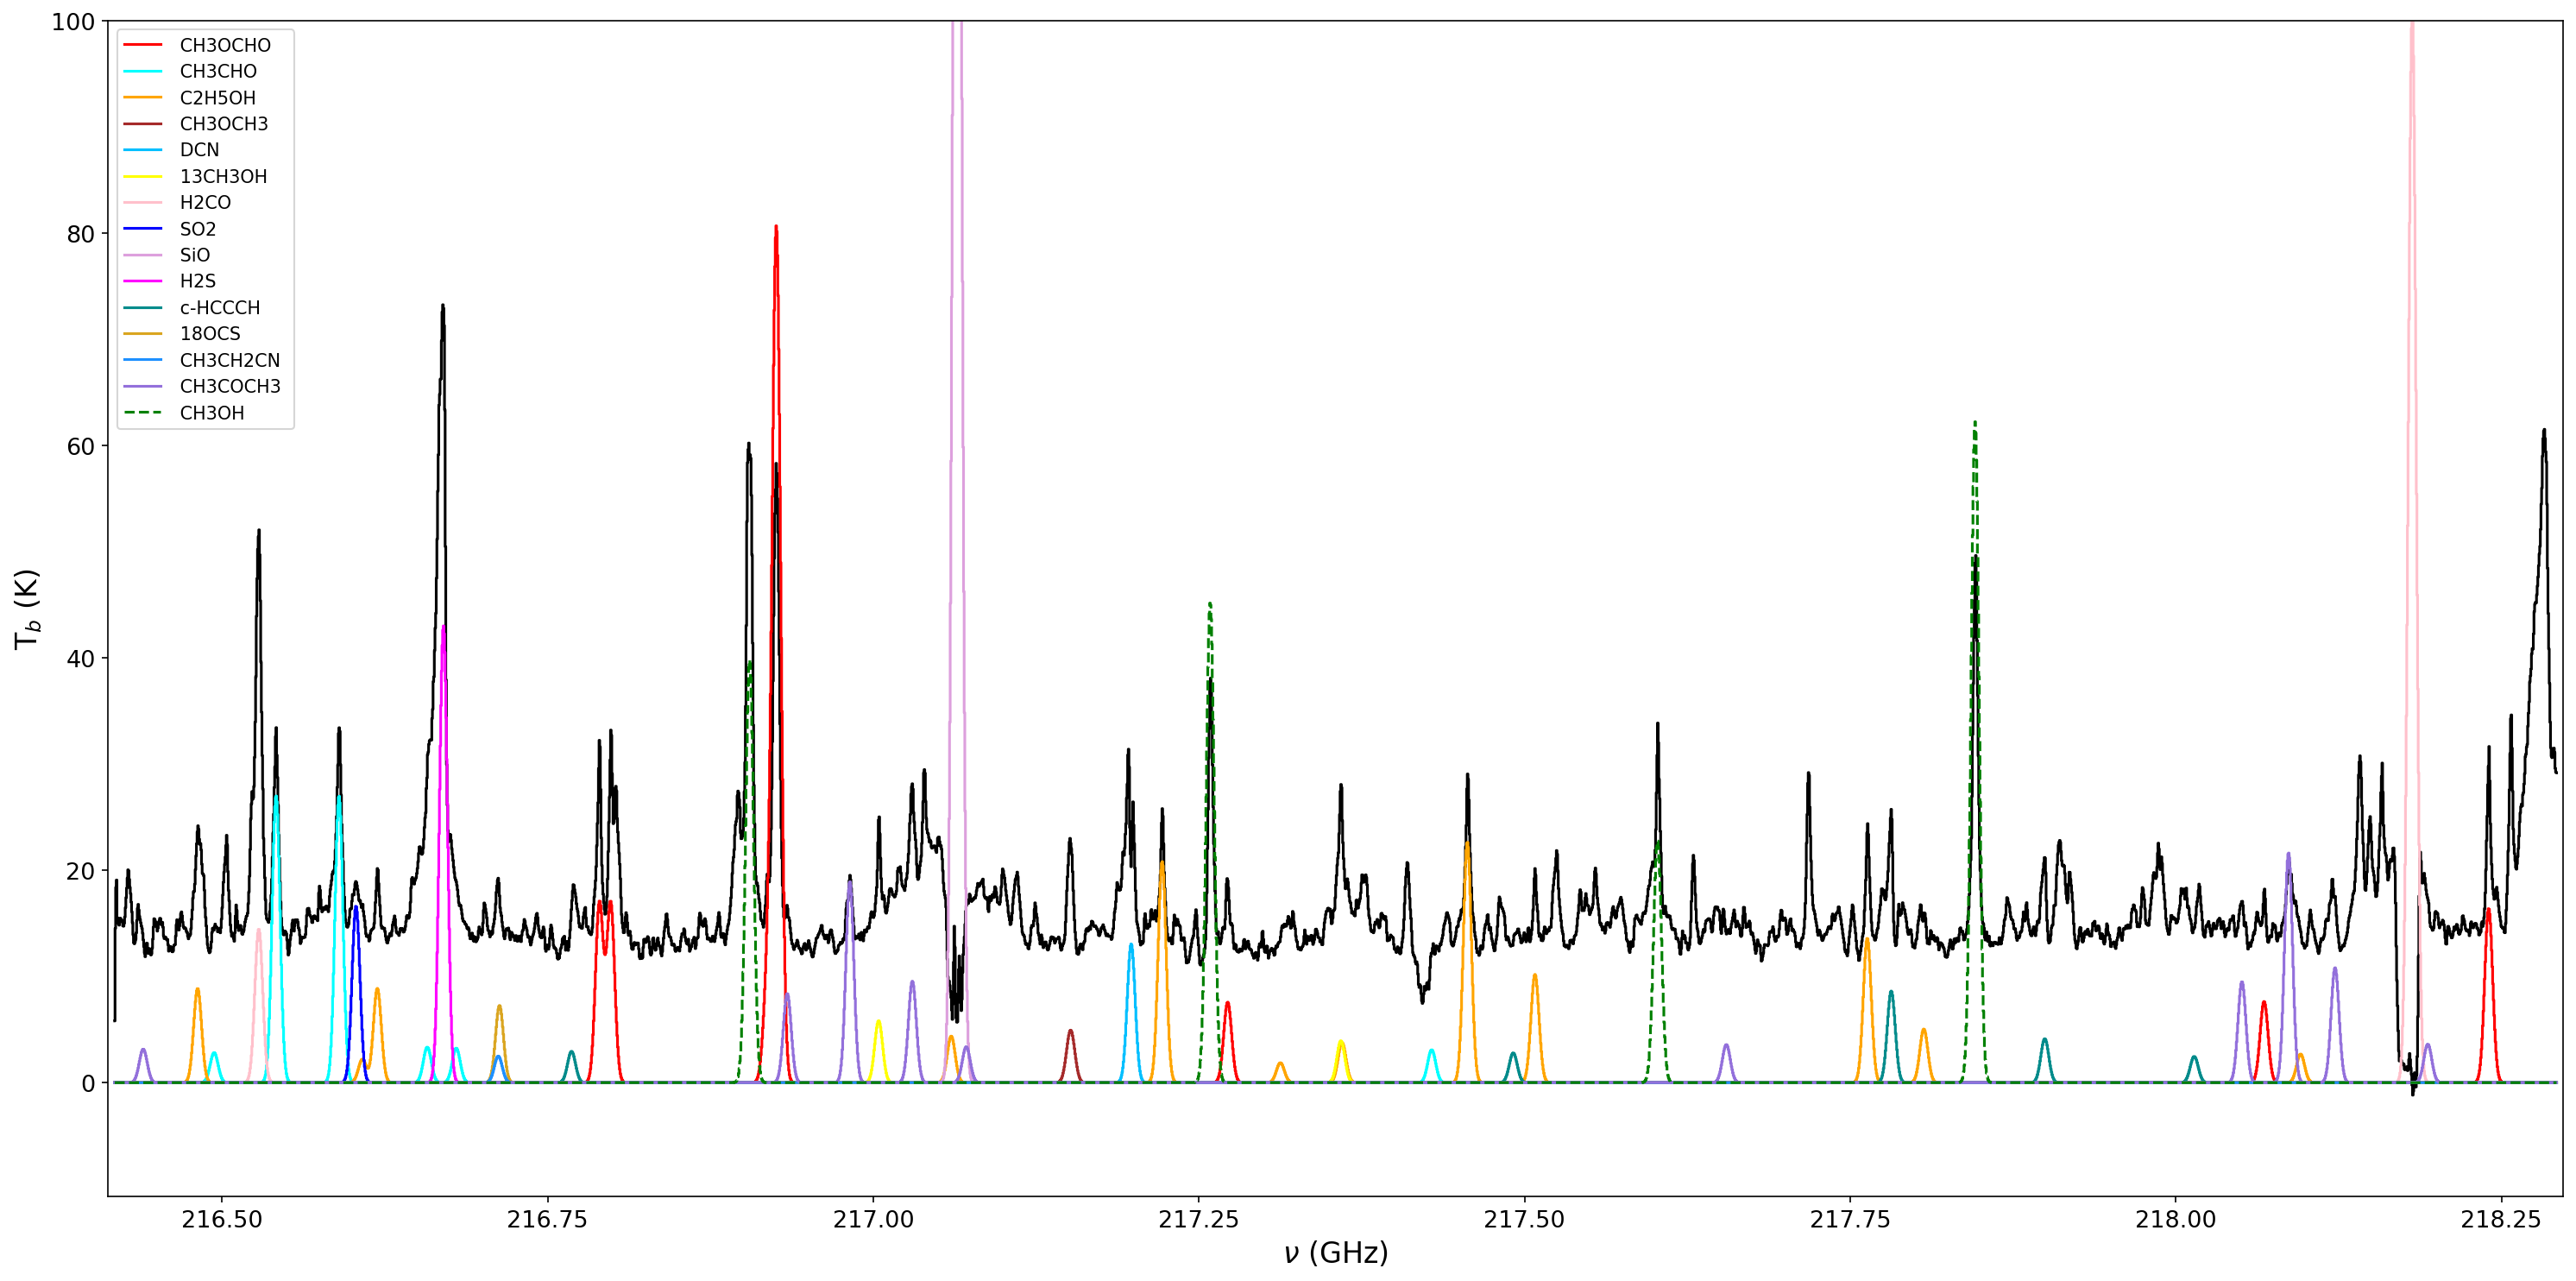

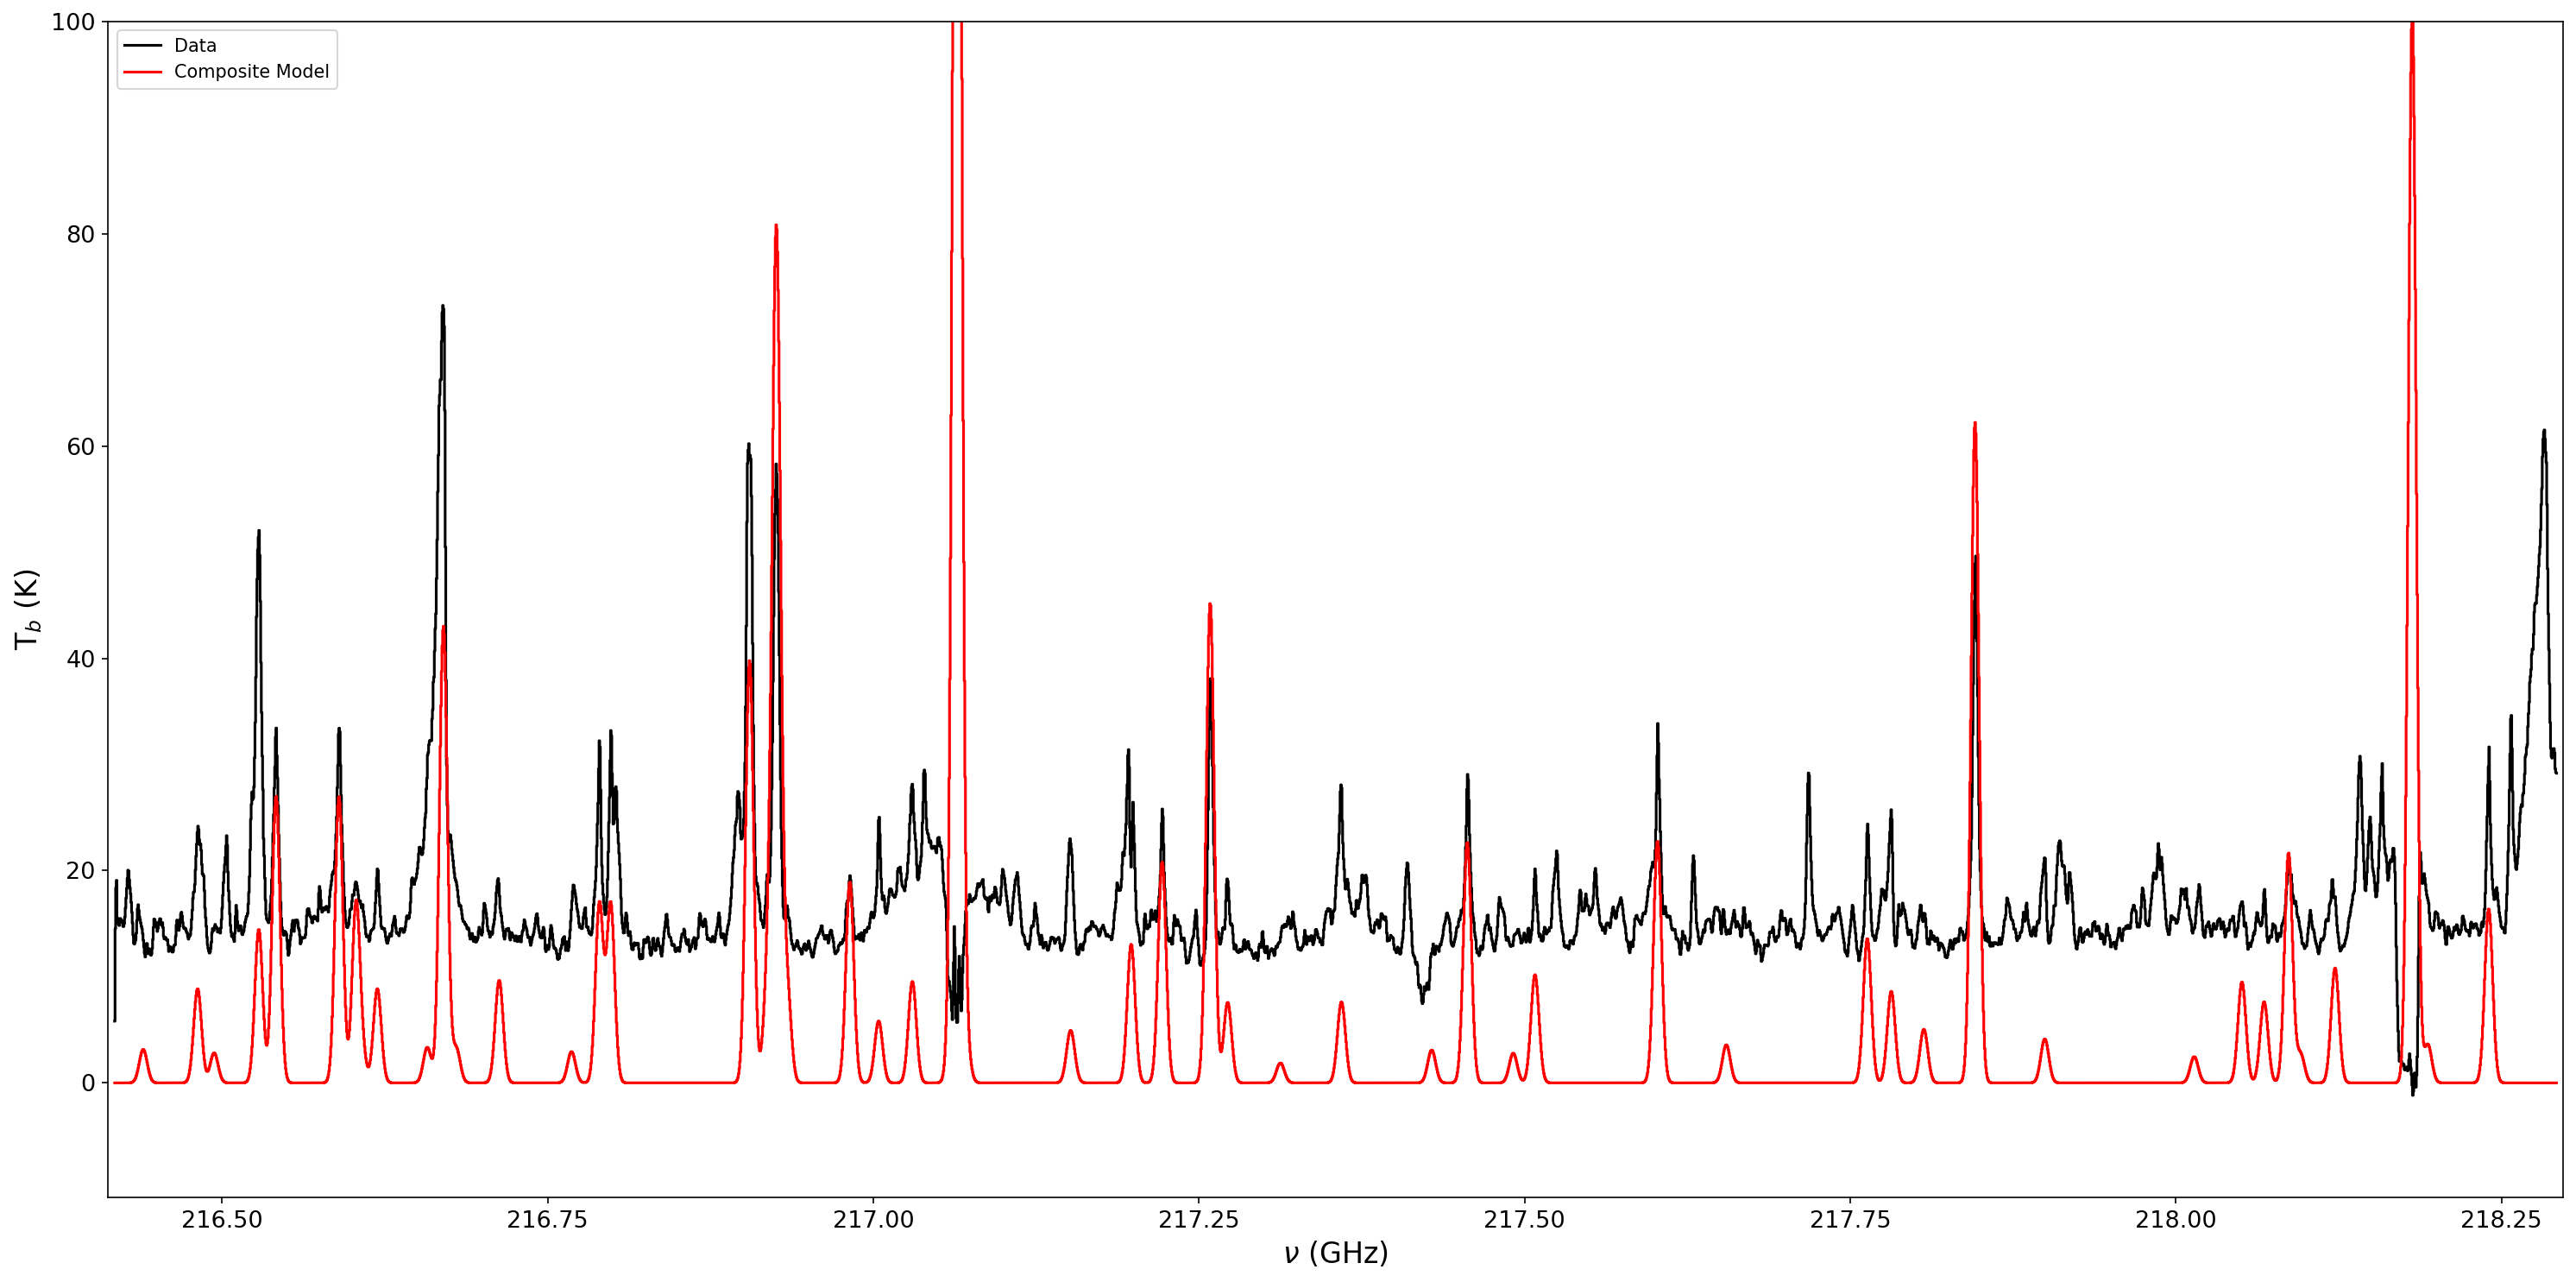

Getting ready - spw1
Corrected decreasing frequency axis
Plotting model spectra
Gathering CDMS table parameters
Begin model loops for  CH3OCHO 
Begin model loops for  CH3CHO 
 C2H5OH  has an incomplete partition function
Estimating by linear fit to log-log Qrot/T relation
Begin model loops for  C2H5OH 
Begin model loops for  CH3OCH3 
No transitions for  DCN  in spw1. Continue
Begin model loops for  OCS 
Begin model loops for  13CH3OH 
Begin model loops for  H2CO 
Begin model loops for  HC3N 
Begin model loops for  C(18)O 
No transitions for  13CS  in spw1. Continue
Begin model loops for  SO2 
Begin model loops for  NH2CHO 
Begin model loops for  HNCO 
Begin model loops for  SO 
No transitions for  SiO  in spw1. Continue
No transitions for  H2S  in spw1. Continue
Begin model loops for  c-HCCCH 
Begin model loops for HC3N v7=1
Begin model loops for  H213CO 
No transitions for  13CH3CN  in spw1. Continue
Begin model loops for  CH2CHCN 
No transitions for  18OCS  in spw1. Continue
Begin mo

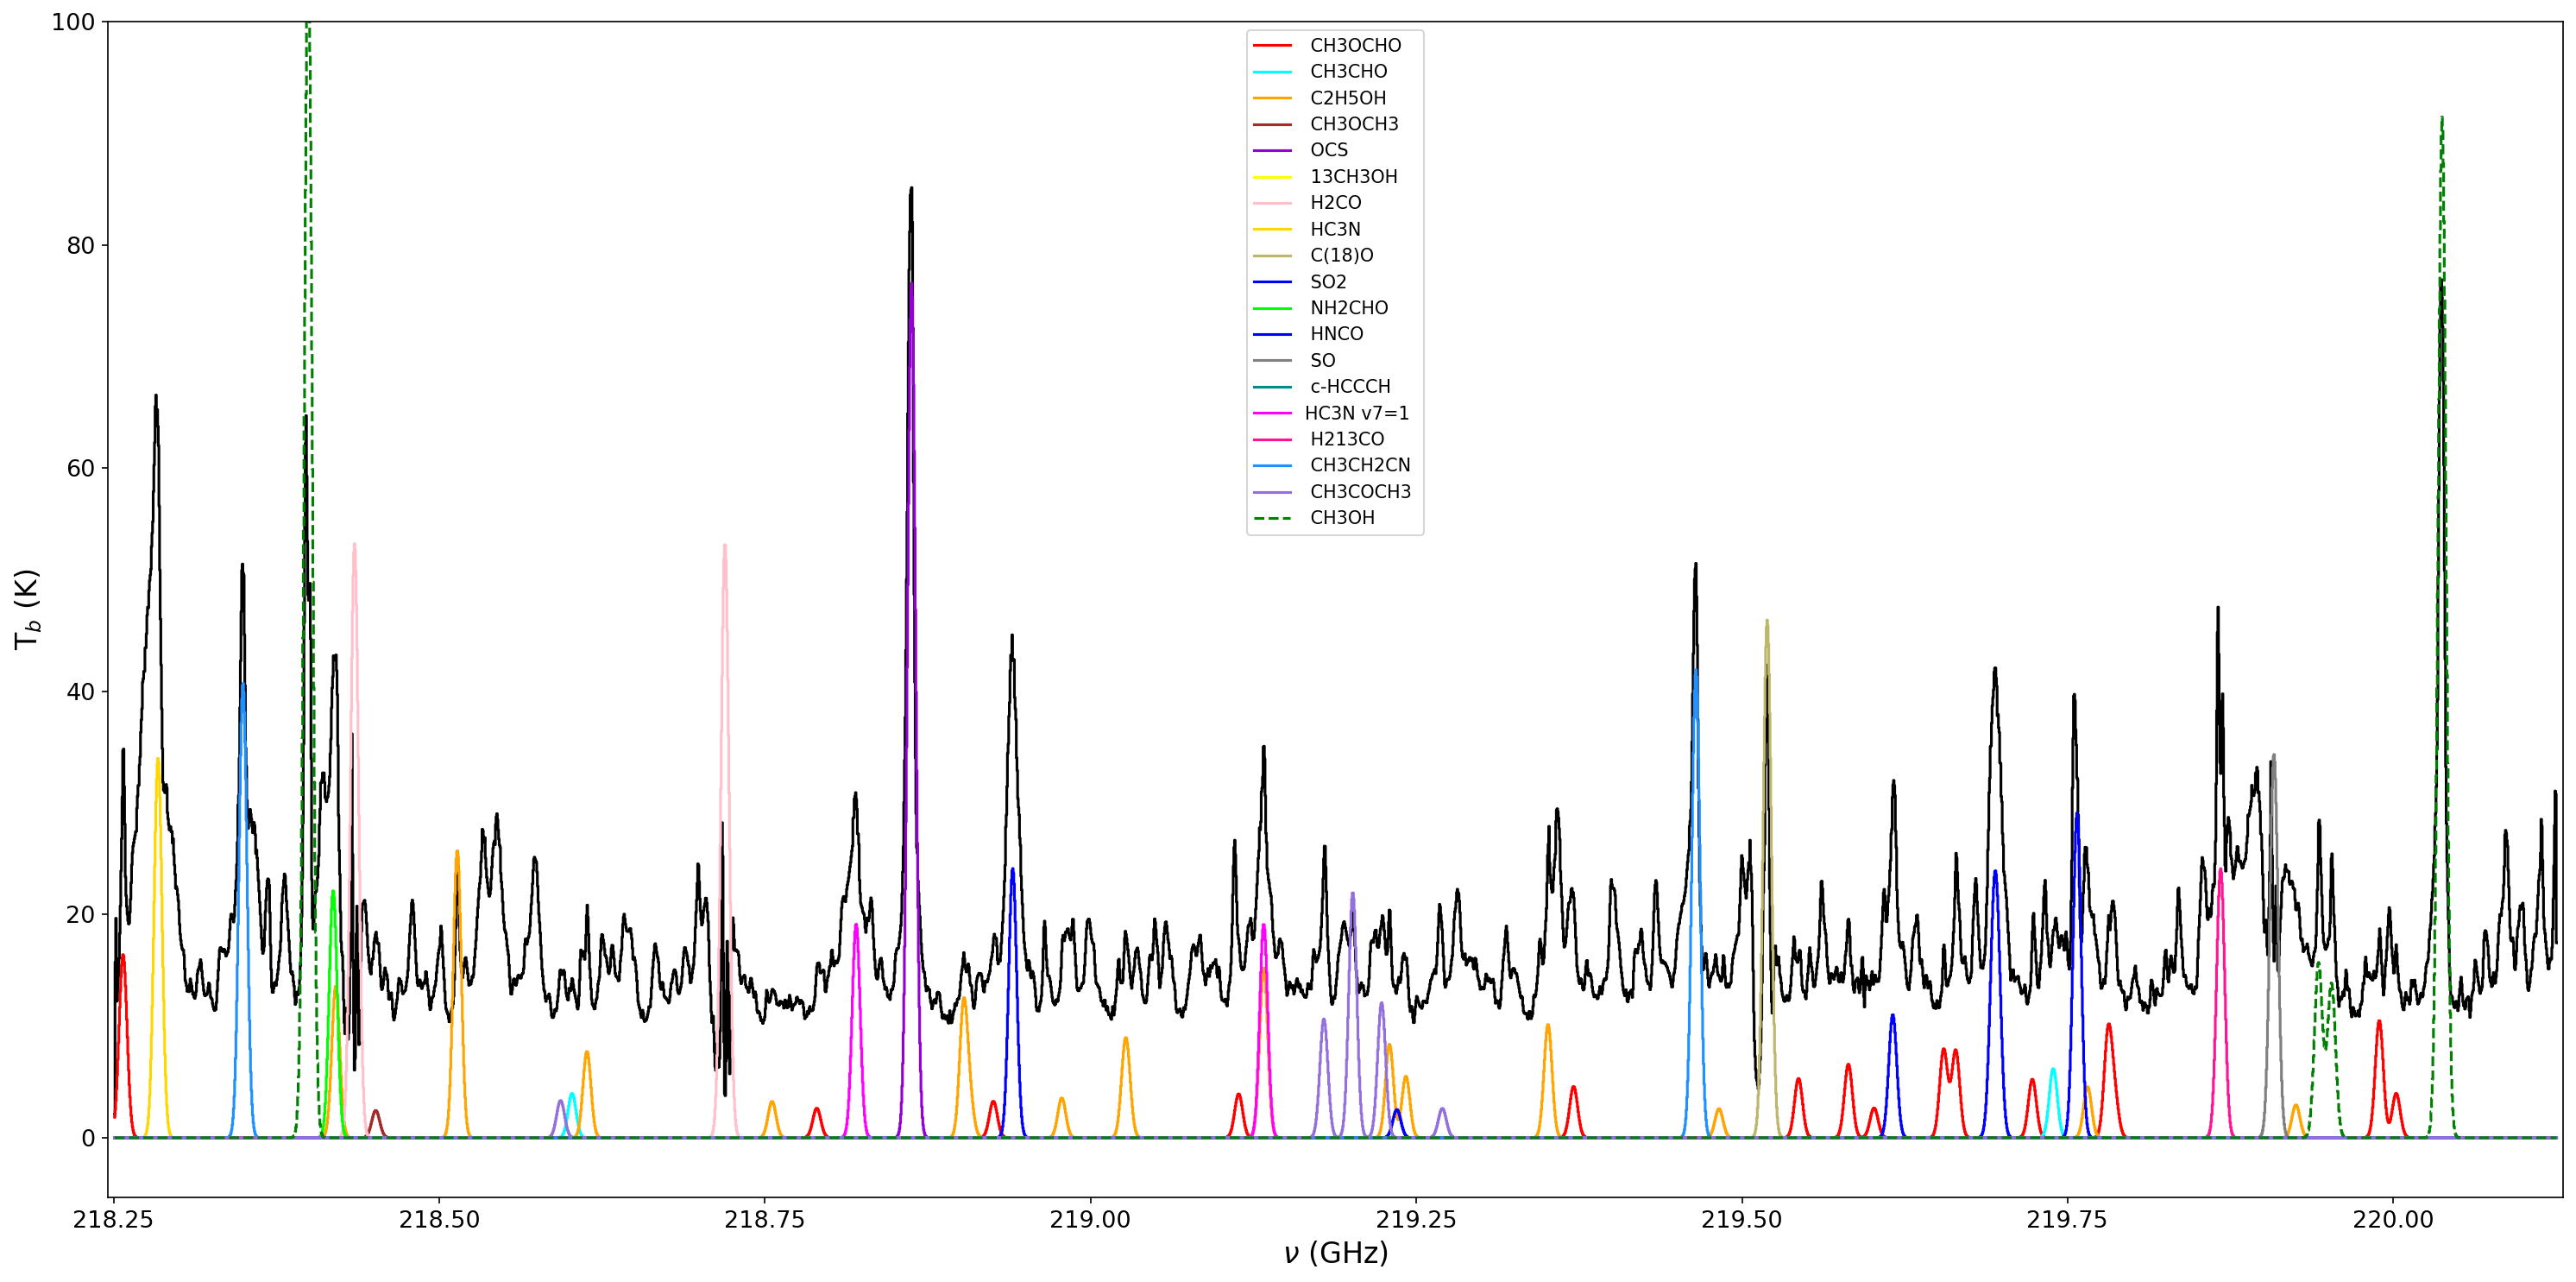

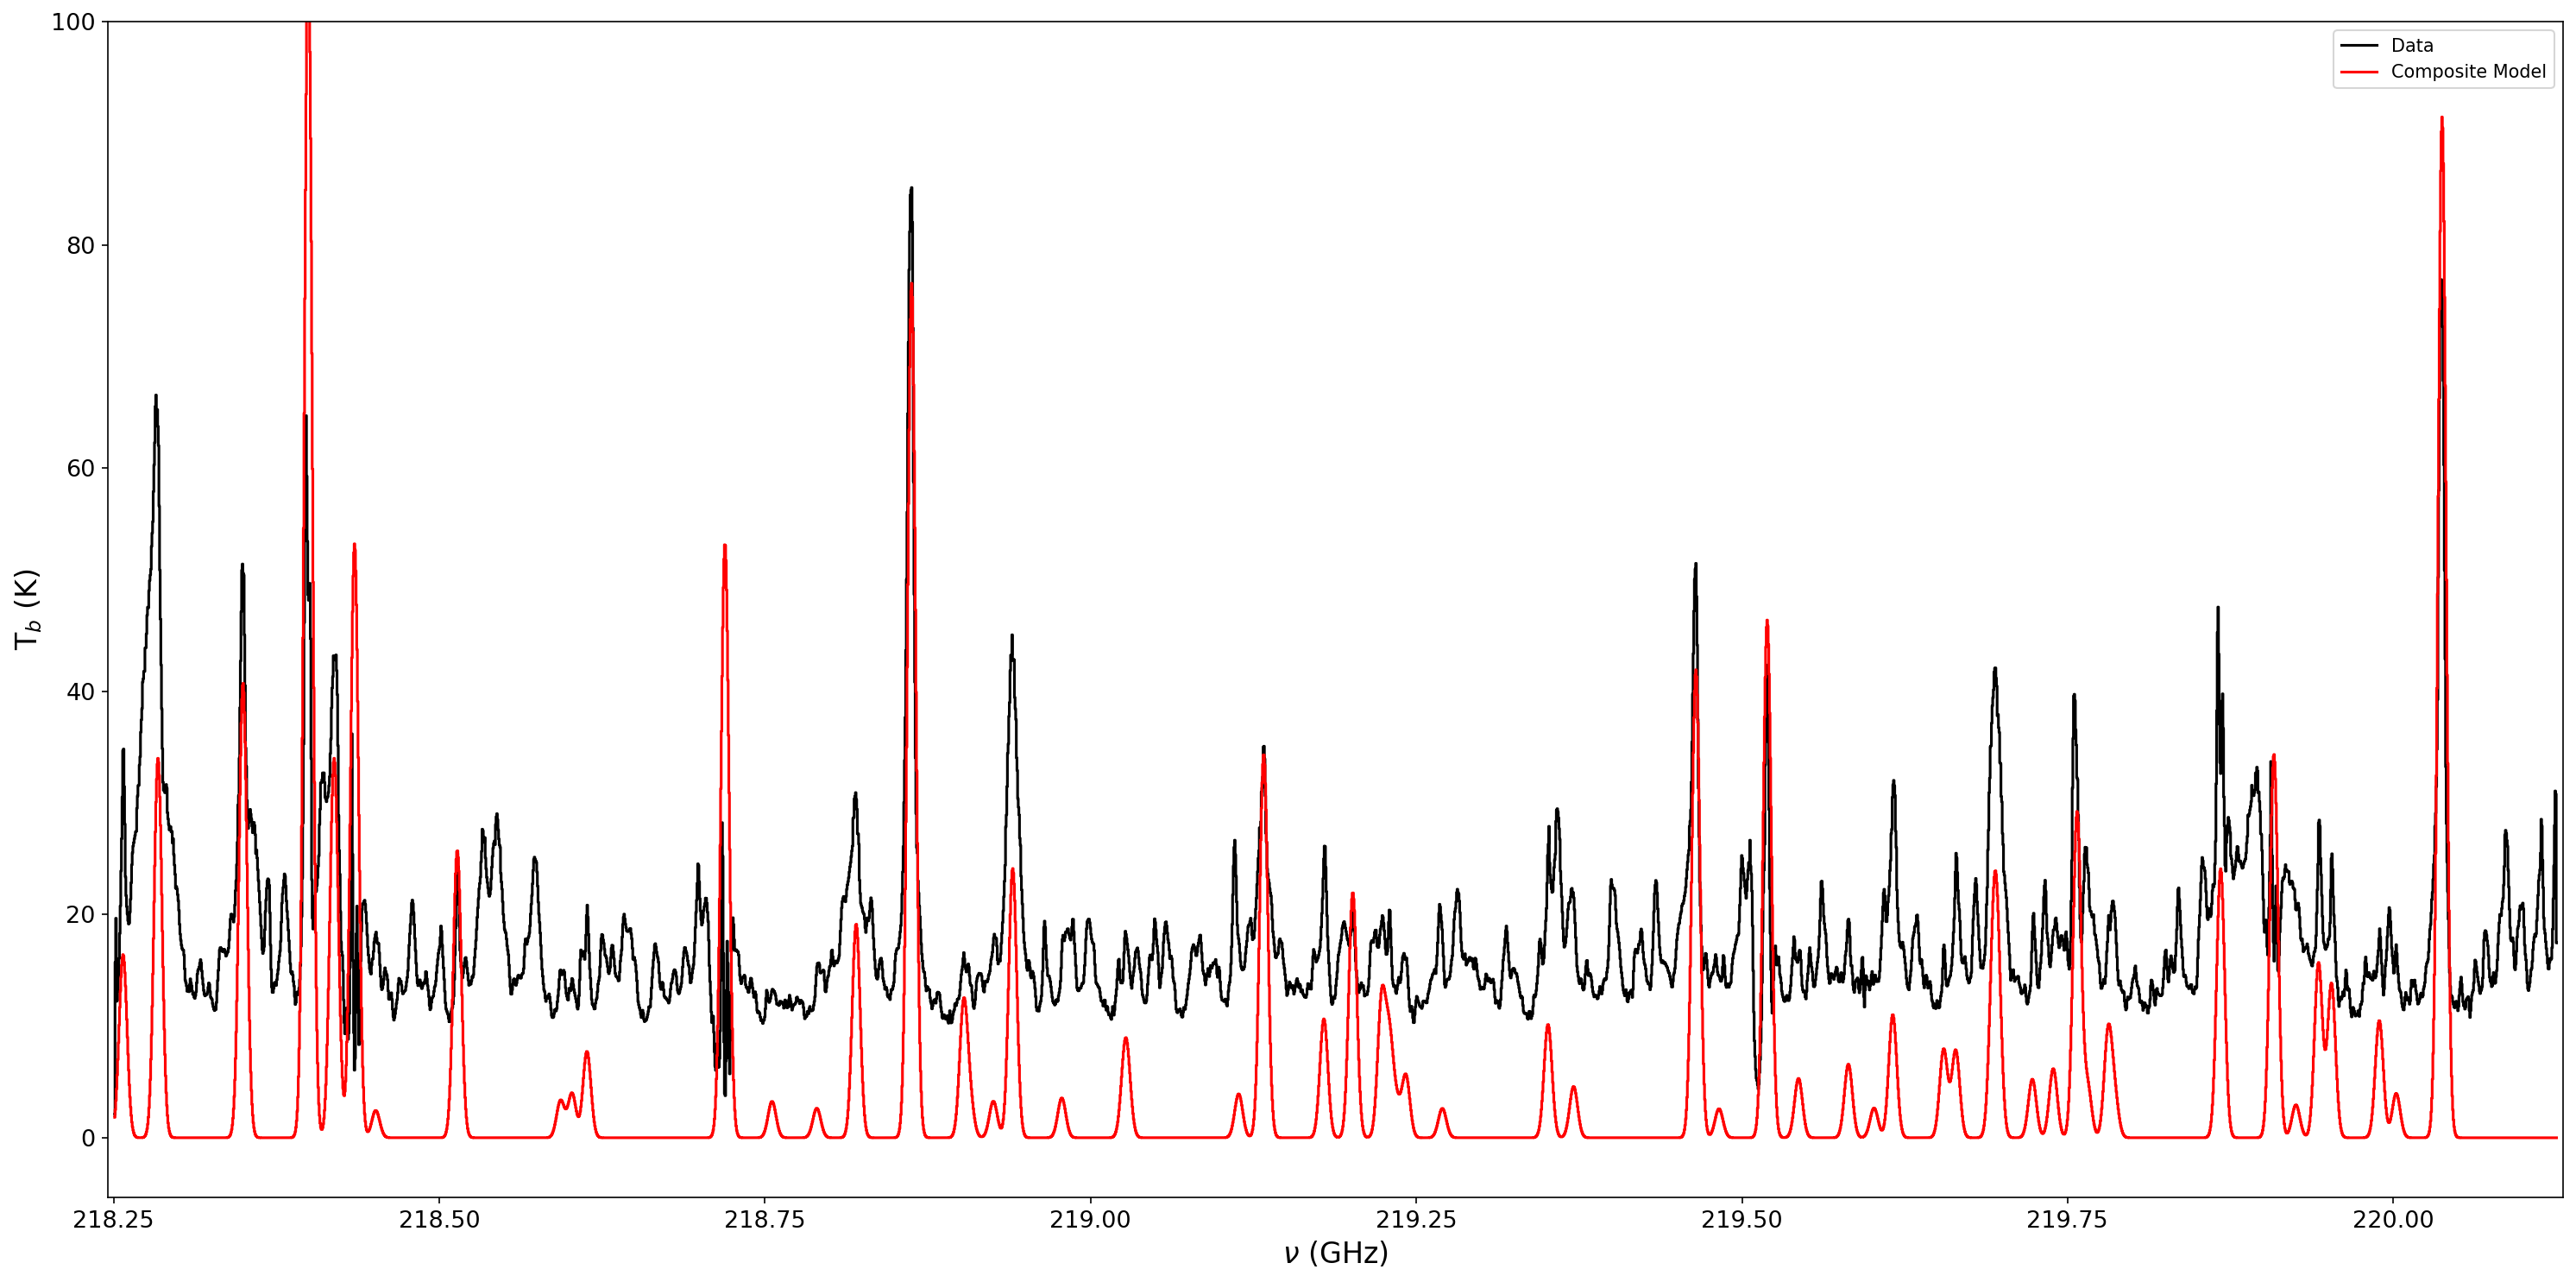

Getting ready - spw2
Plotting model spectra
Gathering CDMS table parameters
Begin model loops for  CH3OCHO 
Begin model loops for  CH3CHO 
 C2H5OH  has an incomplete partition function
Estimating by linear fit to log-log Qrot/T relation
Begin model loops for  C2H5OH 
Begin model loops for  CH3OCH3 
No transitions for  DCN  in spw2. Continue
Begin model loops for  OCS 
Begin model loops for  13CH3OH 
Begin model loops for  H2CO 
No transitions for  HC3N  in spw2. Continue
No transitions for  C(18)O  in spw2. Continue
Begin model loops for  13CS 
Begin model loops for  SO2 
Begin model loops for  NH2CHO 
Begin model loops for  HNCO 
No transitions for  SO  in spw2. Continue
No transitions for  SiO  in spw2. Continue
No transitions for  H2S  in spw2. Continue
Begin model loops for  c-HCCCH 
No transitions for HC3N v7=1 in spw2. Continue
Begin model loops for  H213CO 
Begin model loops for  13CH3CN 
Begin model loops for  CH2CHCN 
No transitions for  18OCS  in spw2. Continue
Begin model lo

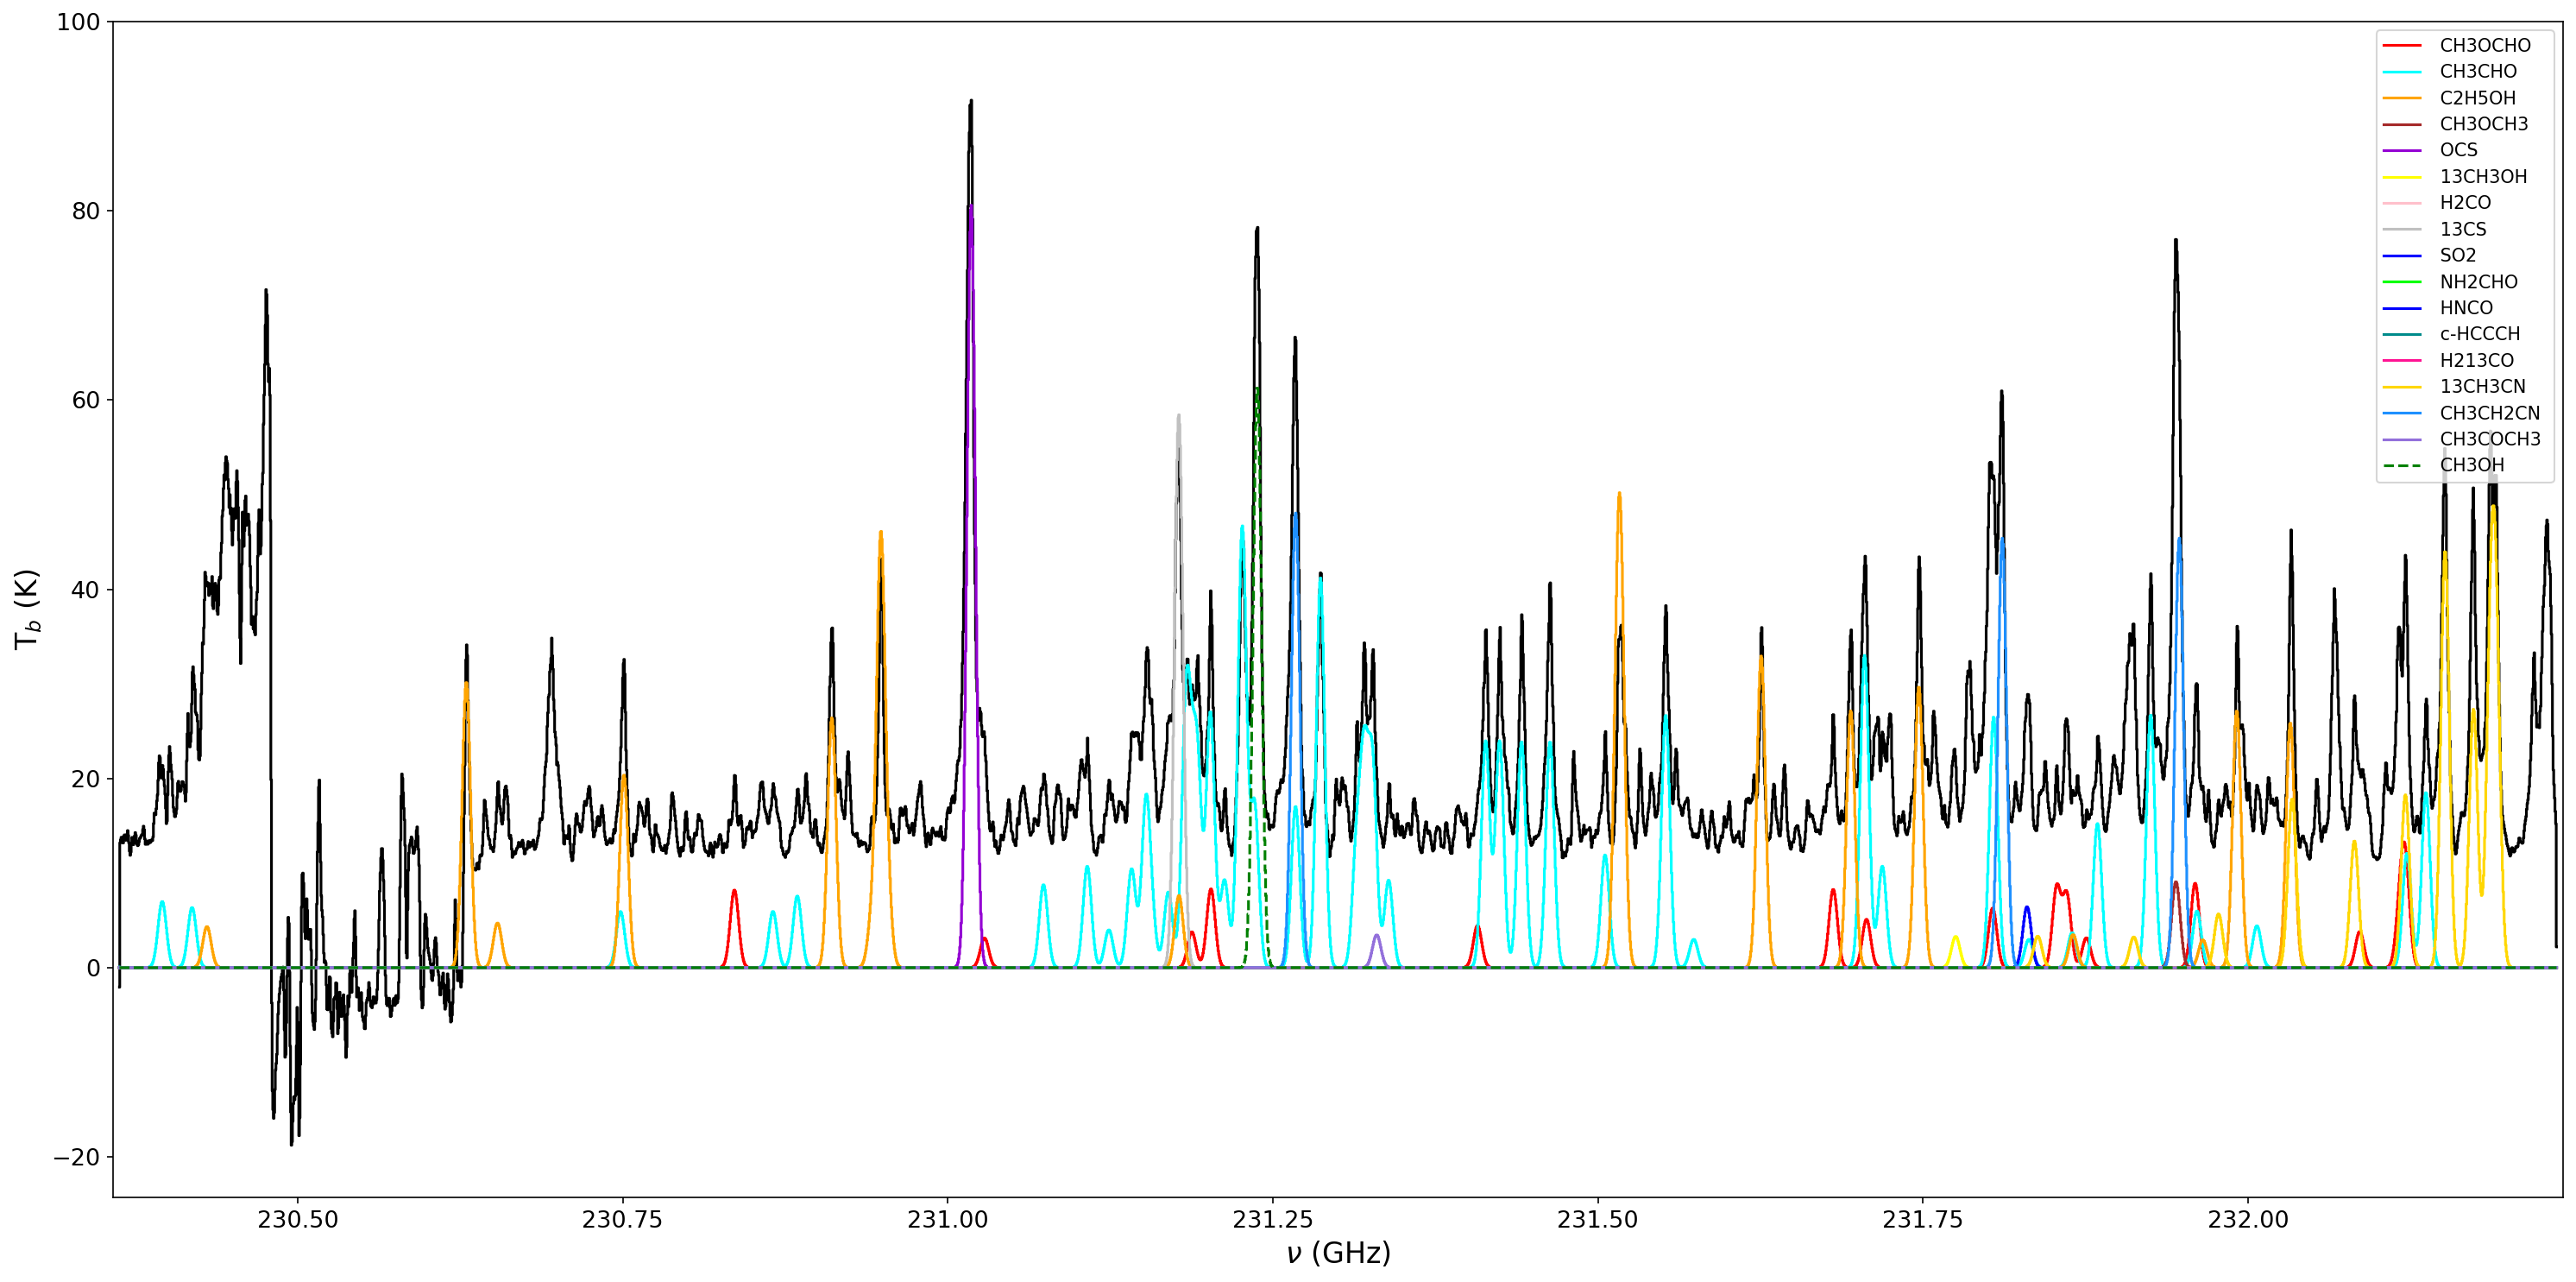

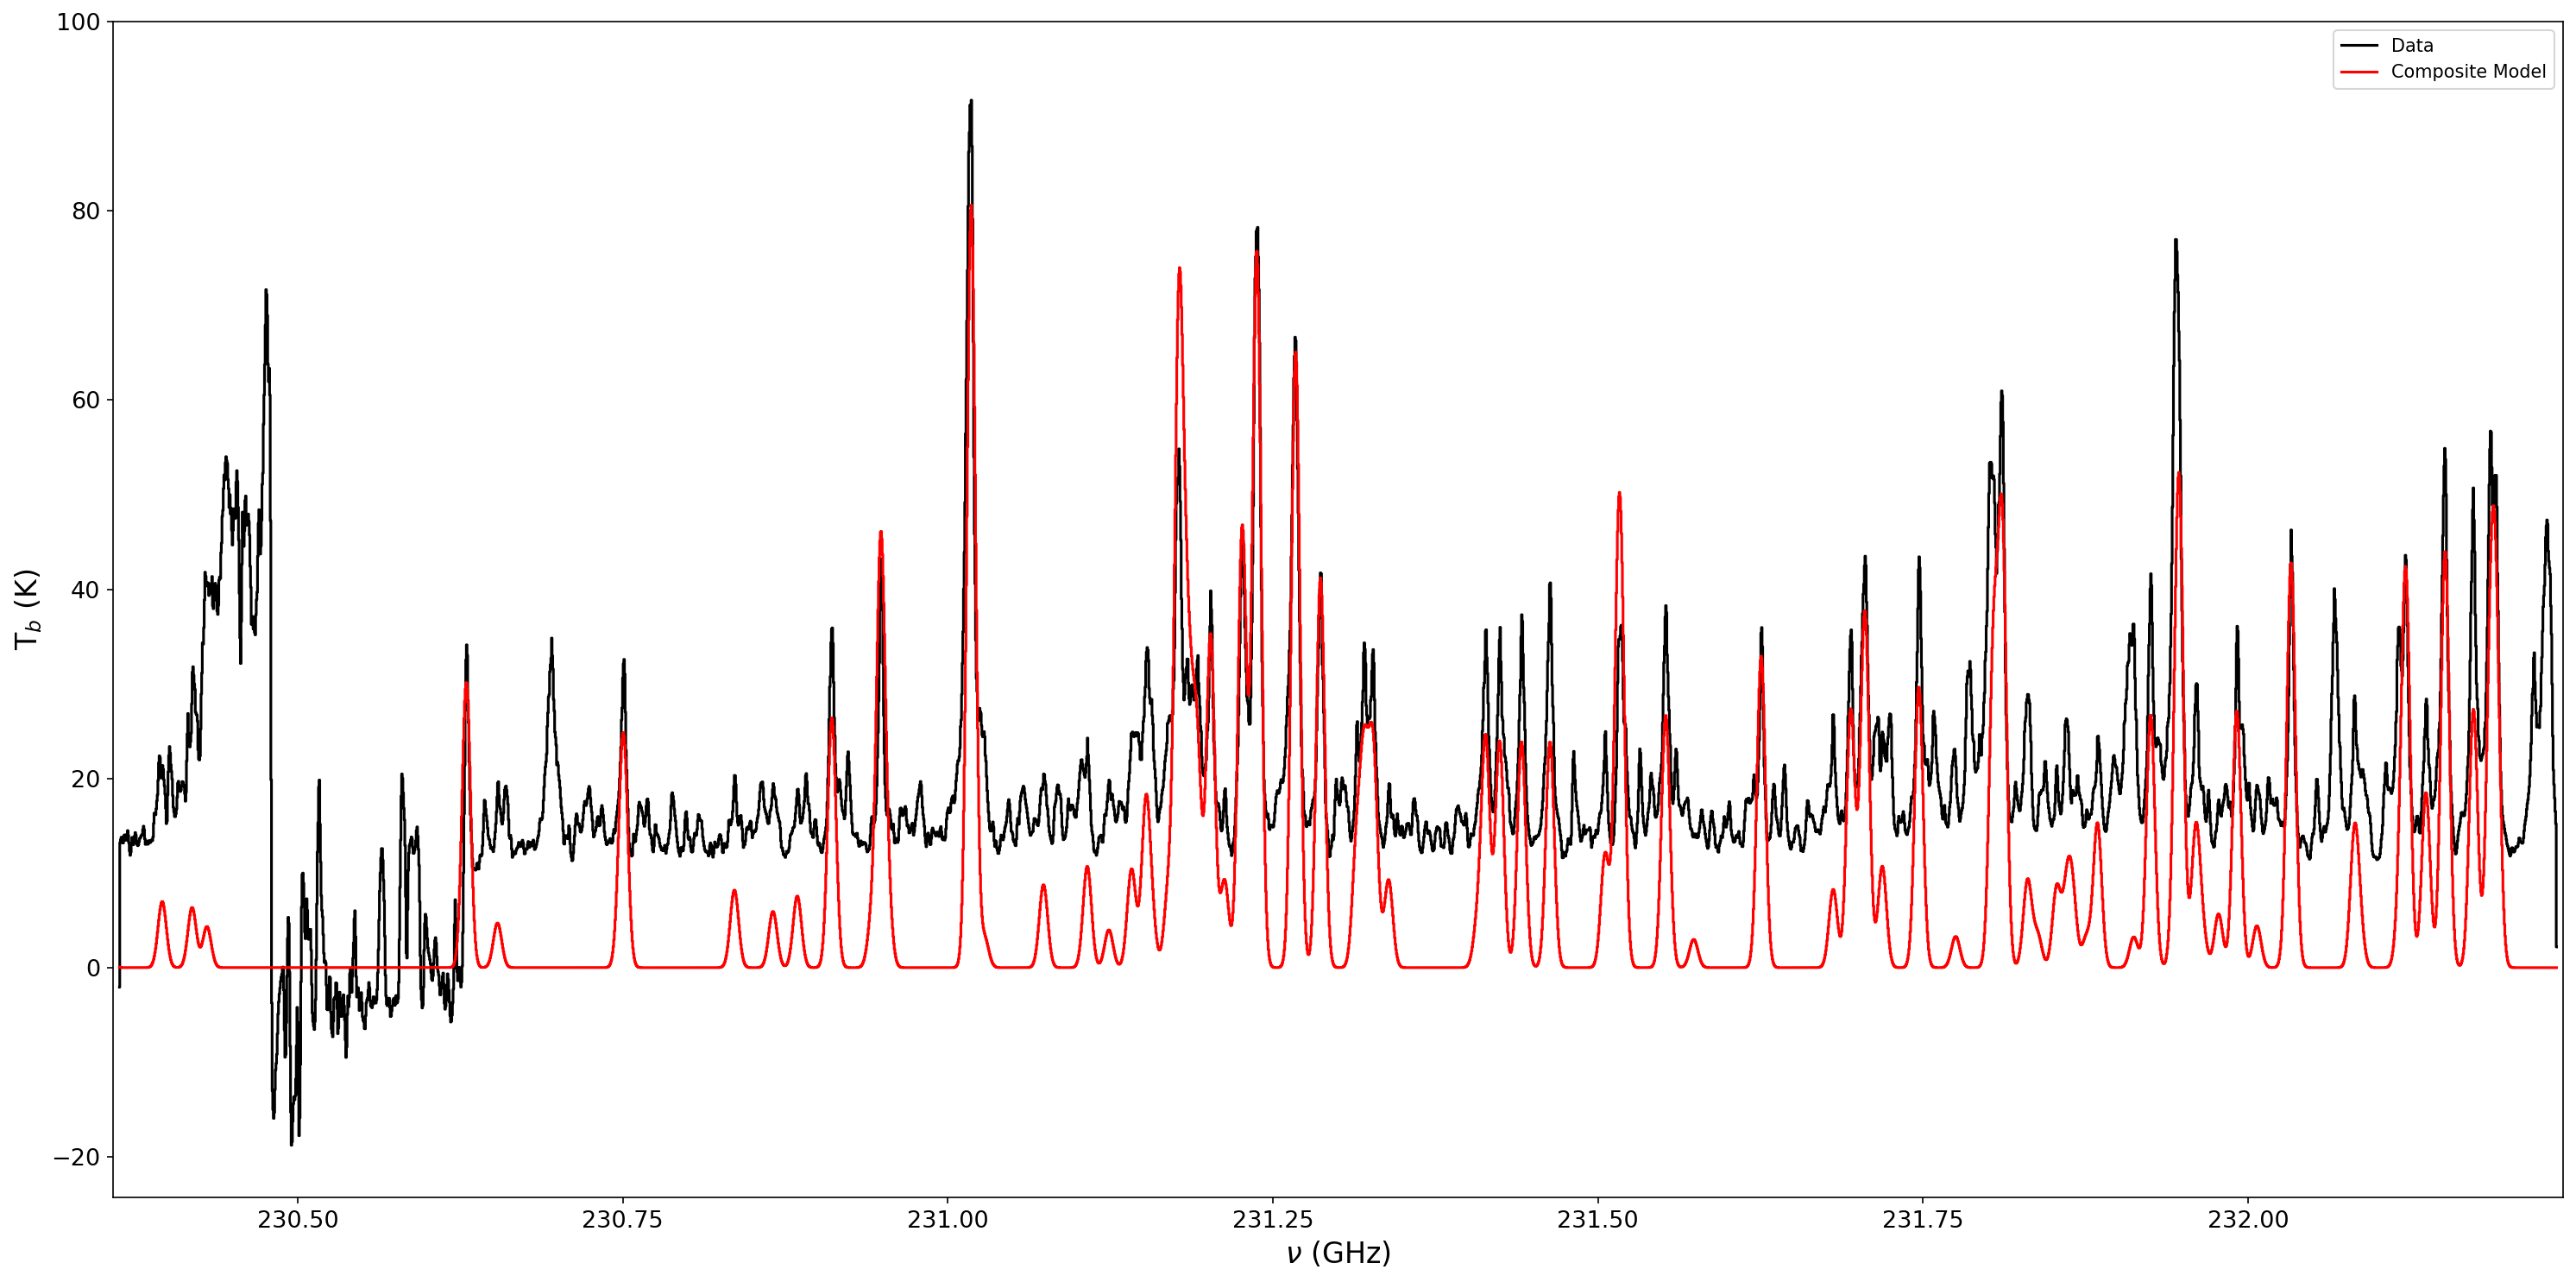

Getting ready - spw3
Plotting model spectra
Gathering CDMS table parameters
Begin model loops for  CH3OCHO 
Begin model loops for  CH3CHO 
 C2H5OH  has an incomplete partition function
Estimating by linear fit to log-log Qrot/T relation
Begin model loops for  C2H5OH 
Begin model loops for  CH3OCH3 
No transitions for  DCN  in spw3. Continue
No transitions for  OCS  in spw3. Continue
Begin model loops for  13CH3OH 
Begin model loops for  H2CO 
No transitions for  HC3N  in spw3. Continue
No transitions for  C(18)O  in spw3. Continue
No transitions for  13CS  in spw3. Continue
Begin model loops for  SO2 
Begin model loops for  NH2CHO 
No transitions for  HNCO  in spw3. Continue
No transitions for  SO  in spw3. Continue
No transitions for  SiO  in spw3. Continue
No transitions for  H2S  in spw3. Continue
Begin model loops for  c-HCCCH 
No transitions for HC3N v7=1 in spw3. Continue
No transitions for  H213CO  in spw3. Continue
No transitions for  13CH3CN  in spw3. Continue
Begin model loop

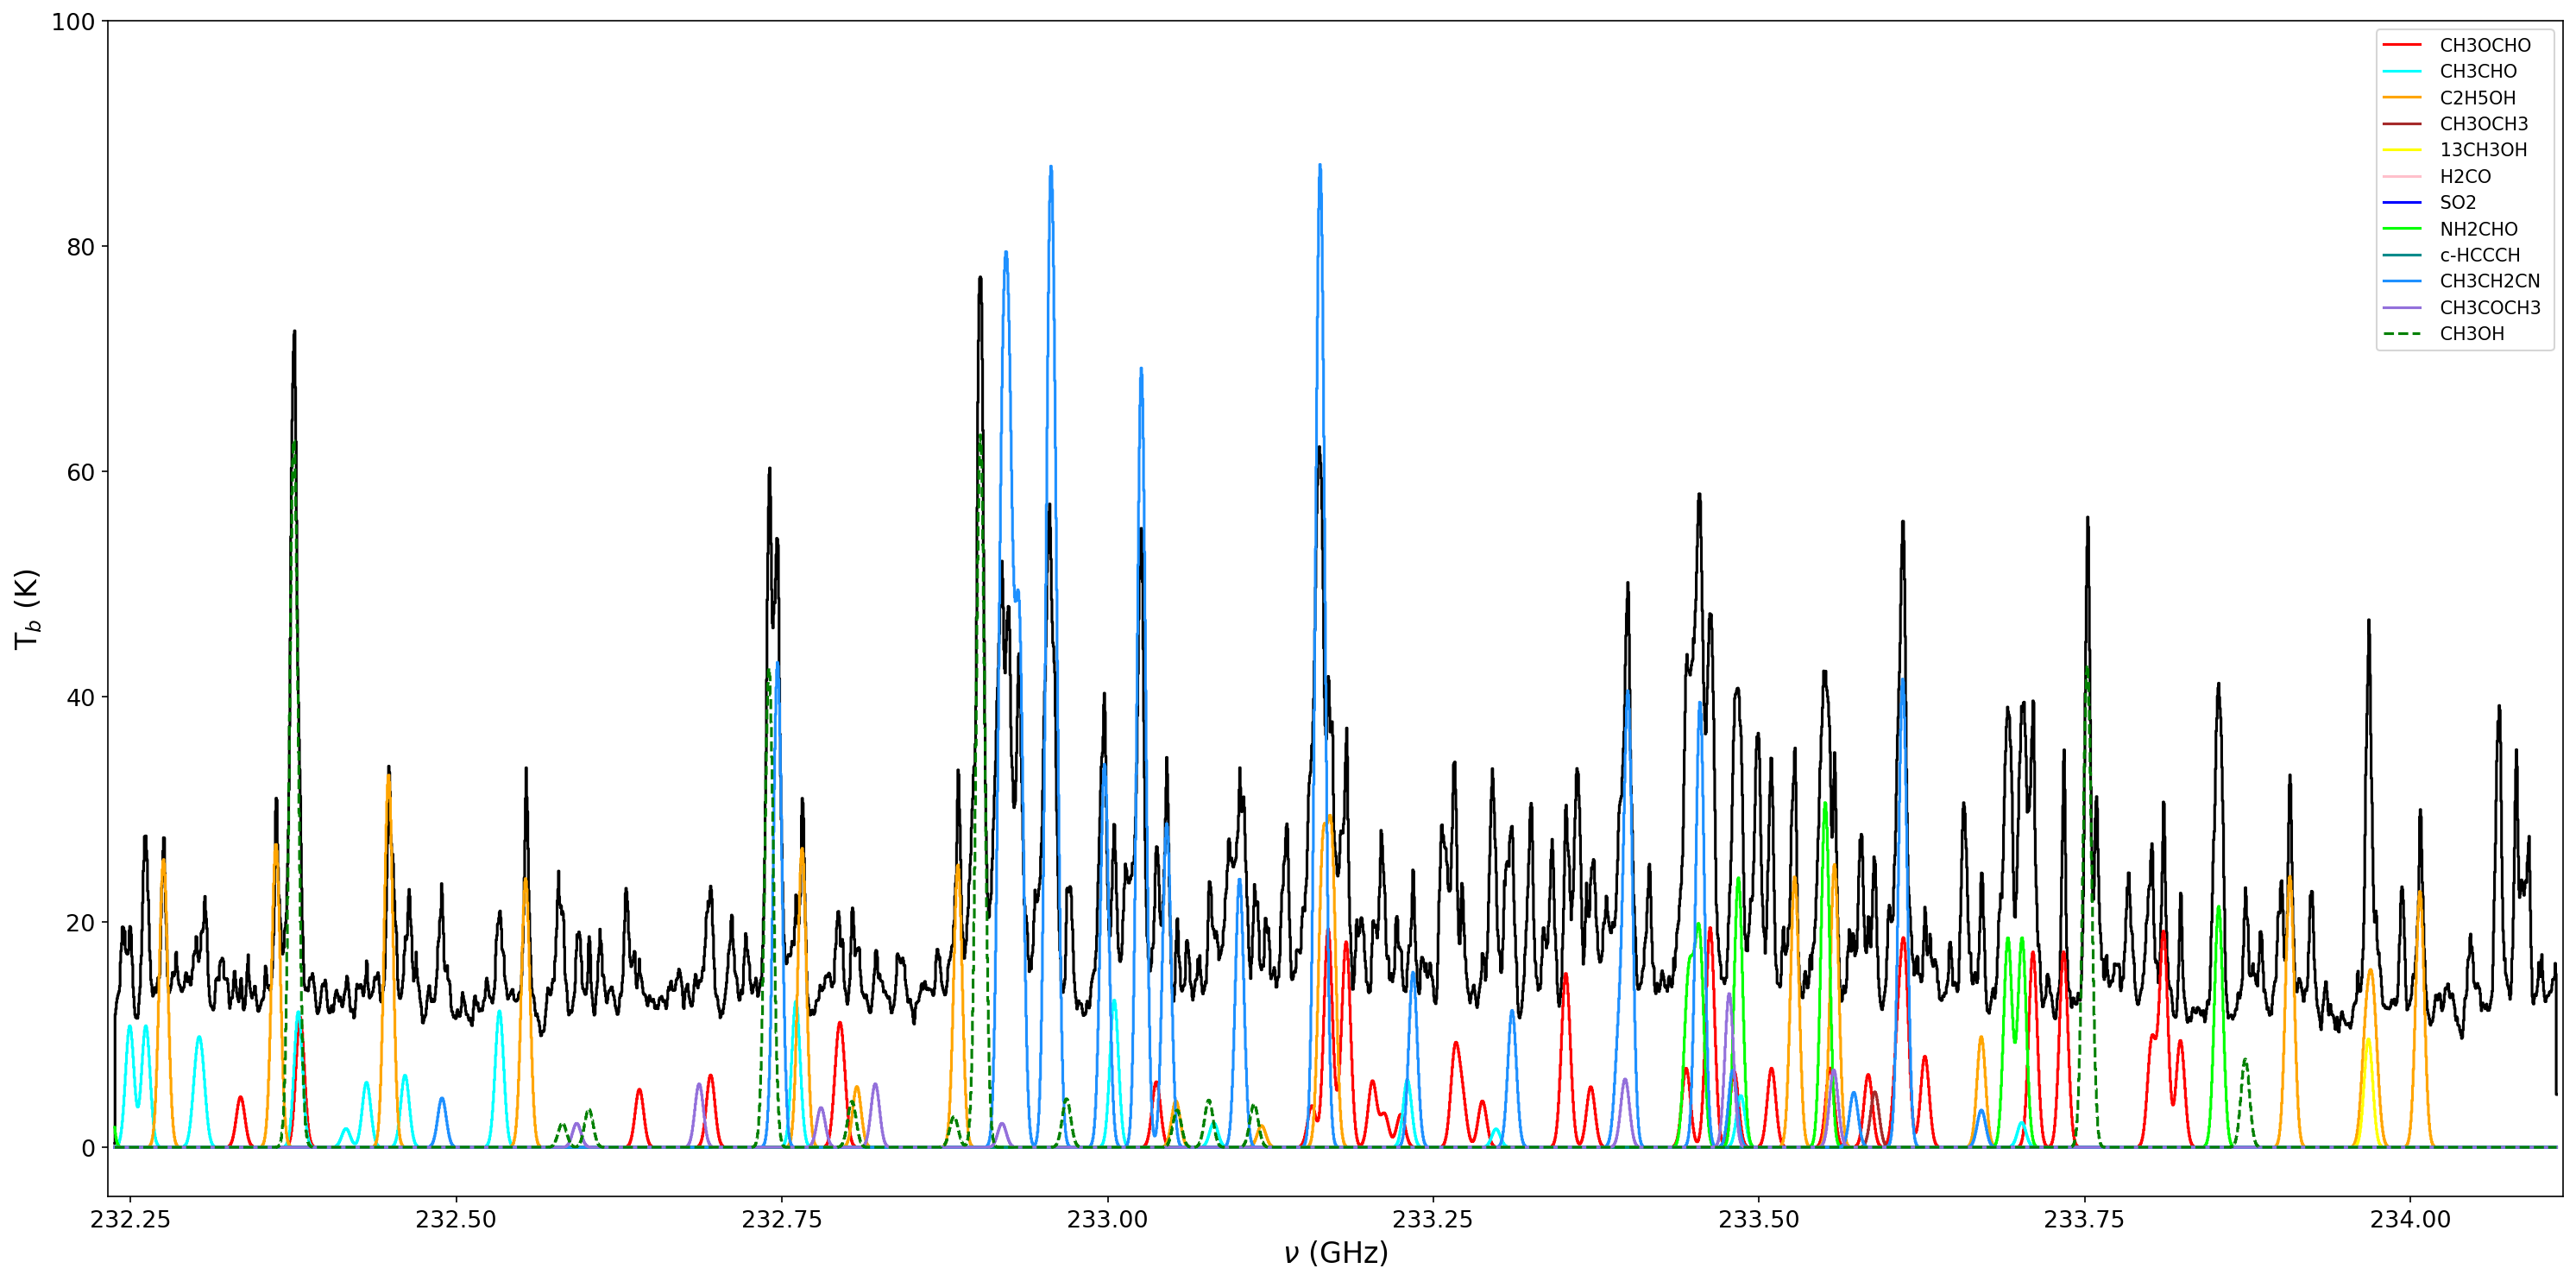

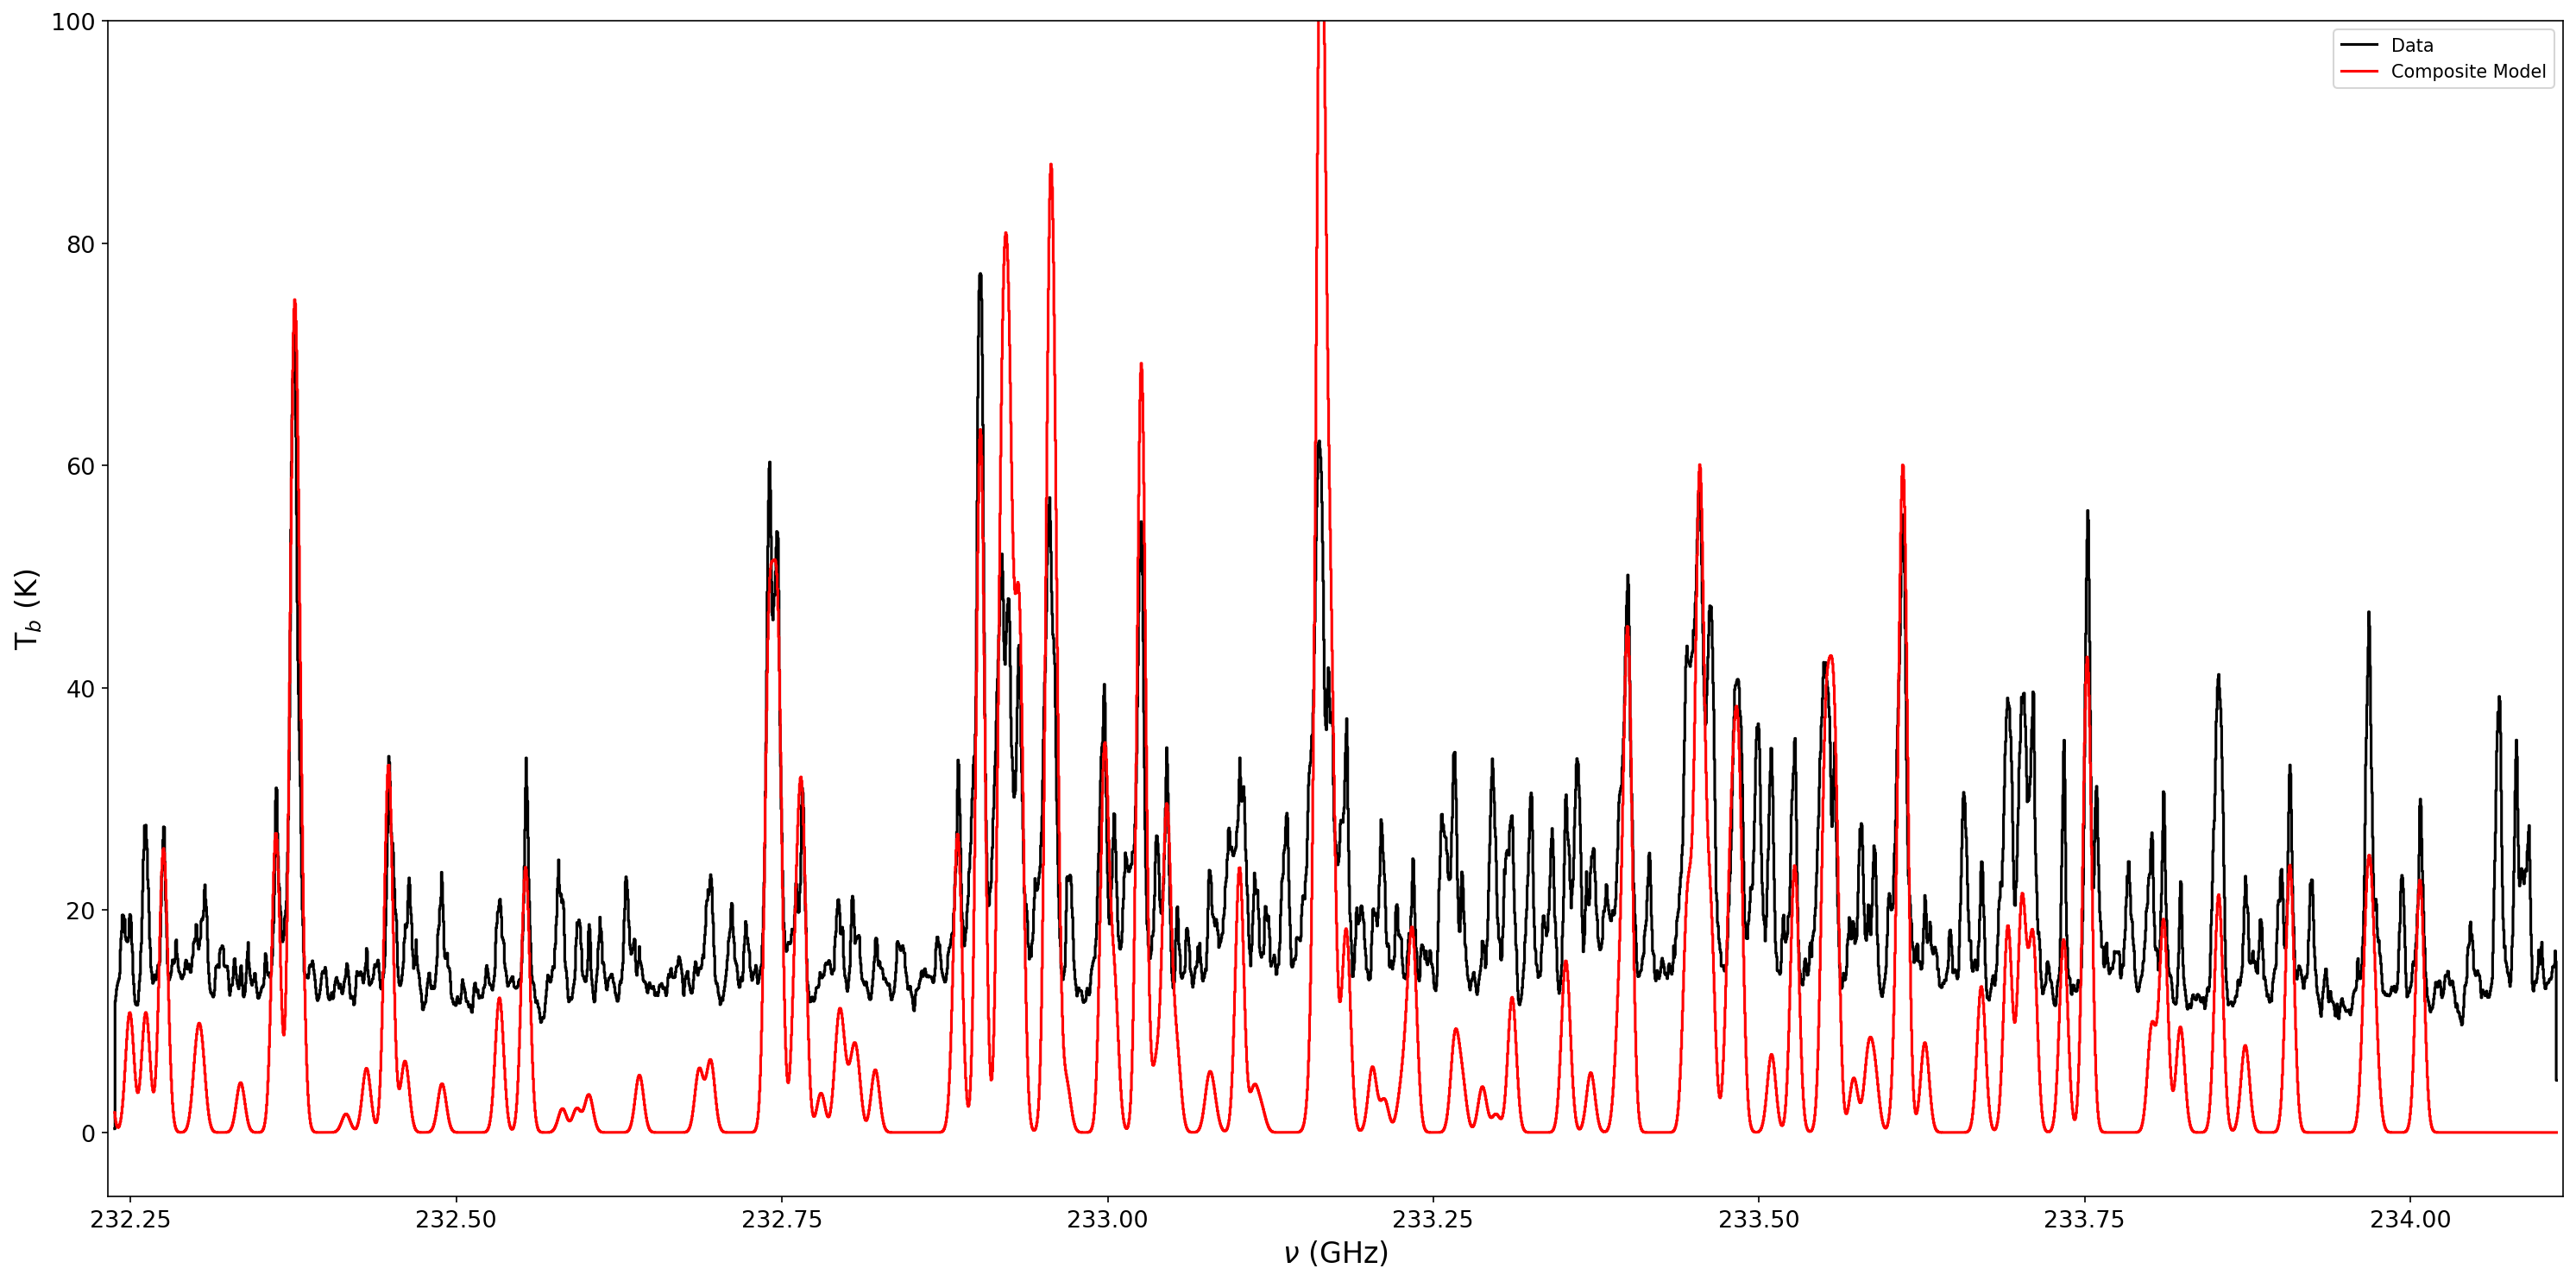

In [4]:
run new_makesyntheticspectra_composite.py

In [10]:
continuumlevel

<Quantity 13.37249721 K>

In [20]:
linedetections[' C2H5OH '].sort('ModelBrightness')
linedetections[' C2H5OH '][::-1][:20]

<QTable length=20>
          QNs             RestFrequency    ...    ModelNupper    
                               GHz         ...      1 / cm2      
         str23               float64       ...      float64      
----------------------- ------------------ ... ------------------
14(0,14)(2)-13(1,13)(2)        230.9913834 ... 259205305799112.06
14(0,14)(0)-13(0,13)(0)         232.491318 ... 206533585968417.78
14(1,14)(0)-13(1,13)(0)        231.6687419 ... 206435629497225.06
13(2,11)(0)-12(2,10)(0)        230.6725581 ...  194763758856287.8
19(5,15)(2)-19(4,16)(2)        231.7376214 ... 227398196279961.84
18(5,14)(2)-18(4,15)(2)        232.0346421 ...  230166317950967.5
20(5,16)(2)-20(4,17)(2)        231.5609215 ...  223303227422348.0
17(5,13)(2)-17(4,14)(2)         232.404841 ... 231490429310477.53
21(5,17)(2)-21(4,18)(2)        231.5585678 ... 218008506282982.06
16(5,12)(2)-16(4,13)(2)        232.8088625 ... 231266642937687.53
16(5,11)(2)-16(4,12)(2)        230.9537832 ... 231262449606165.12
22(5,18)(2)-22(4,19)(2)        231.7900568 ...  211648635654989.7
15(5,11)(2)-15(4,12)(2) 233.21550140000002 ... 229406404361684.72
15(5,10)(2)-15(4,11)(2)        232.0758455 ...  229404158547391.8
21(5,16)(2)-21(4,17)(2)        218.5545074 ... 217953381619191.06
23(5,19)(2)-23(4,20)(2)        232.3185139 ... 204363540894016.62
14(5,10)(2)-14(4,11)(2)        233.6015544 ...  225839060108320.4
 14(5,9)(2)-14(4,10)(2) 232.92852580000002 ... 225837944693205.66
24(5,20)(2)-24(4,21)(2)         233.208542 ...  196294770436026.0
 13(5,9)(2)-13(4,10)(2)        233.9512316 ...  220514067907018.4

In [4]:
CDMS.query_lines(min_frequency=259.09*u.GHz,max_frequency=261.3*u.GHz,min_strength=-500,molecule=cdmsname,get_query_payload=False)[0:]

<Table length=169>
    FREQ      ERR    LGINT    DR     ELO    ...  F2l   F3l     name     Lab 
    MHz       MHz   MHz nm2         1 / cm  ...                             
  float64   float64 float64 int64  float64  ... int64 int64   str10     bool
----------- ------- ------- ----- --------- ... ----- ----- ---------- -----
259133.7086  0.0152 -7.3131     3  517.4071 ...    --    -- C2H5OH,v=0 False
259182.0018  0.0067 -6.2913     3  149.3284 ...    --    -- C2H5OH,v=0 False
259209.0895  0.0063 -7.3056     3  206.6997 ...    --    -- C2H5OH,v=0 False
259209.0895  0.0063 -7.3056     3  206.6997 ...    --    -- C2H5OH,v=0 False
259253.2486  0.0112 -5.2395     3  571.8752 ...    --    -- C2H5OH,v=0 False
259269.4713  0.0237 -6.1517     3  800.4537 ...    --    -- C2H5OH,v=0 False
259306.4346  0.5848 -7.0481     3 1187.2053 ...    --    -- C2H5OH,v=0 False
259312.6577  0.0237 -6.1513     3  800.4533 ...    --    -- C2H5OH,v=0 False
259317.0378   0.053 -7.5454     3  880.3542 ...    --    -- C2H5OH,v=0 False
        ...     ...     ...   ...       ... ...   ...   ...        ...   ...
261244.1102   0.005 -5.9035     3   89.7138 ...    --    -- C2H5OH,v=0 False
261257.0434  0.1632 -6.5698     3 1243.4694 ...    --    -- C2H5OH,v=0 False
261263.3943  0.0133  -7.033     3  452.9985 ...    --    -- C2H5OH,v=0 False
261266.7059  0.3452 -7.0535     3 1174.7818 ...    --    -- C2H5OH,v=0 False
261266.7702  0.3452 -7.0535     3 1174.7818 ...    --    -- C2H5OH,v=0 False
261270.8953  0.0123 -7.0715     3  520.5265 ...    --    -- C2H5OH,v=0 False
261282.3232   0.006 -4.7188     3  163.1055 ...    --    -- C2H5OH,v=0 False
261286.3062  0.0025 -3.8023     3  105.4755 ...    --    -- C2H5OH,v=0 False
 261295.723   0.038 -7.3478     3  178.5304 ...    --    -- C2H5OH,v=0 False
 261295.723   0.038 -7.3478     3  178.5304 ...    --    -- C2H5OH,v=0 False

In [2]:
columndict[' CH3OCH3 ']

<Quantity 3.e+17 1 / cm2>

Spectra and stds are sequential order
Absolute model line width: 5.768377349628877 km / s

Getting ready - spw0
Corrected decreasing frequency axis
Plotting model spectra
Gathering CDMS table parameters
Begin model loops for JPL CH3OH
Begin CDMS CH3OH modeling

yay


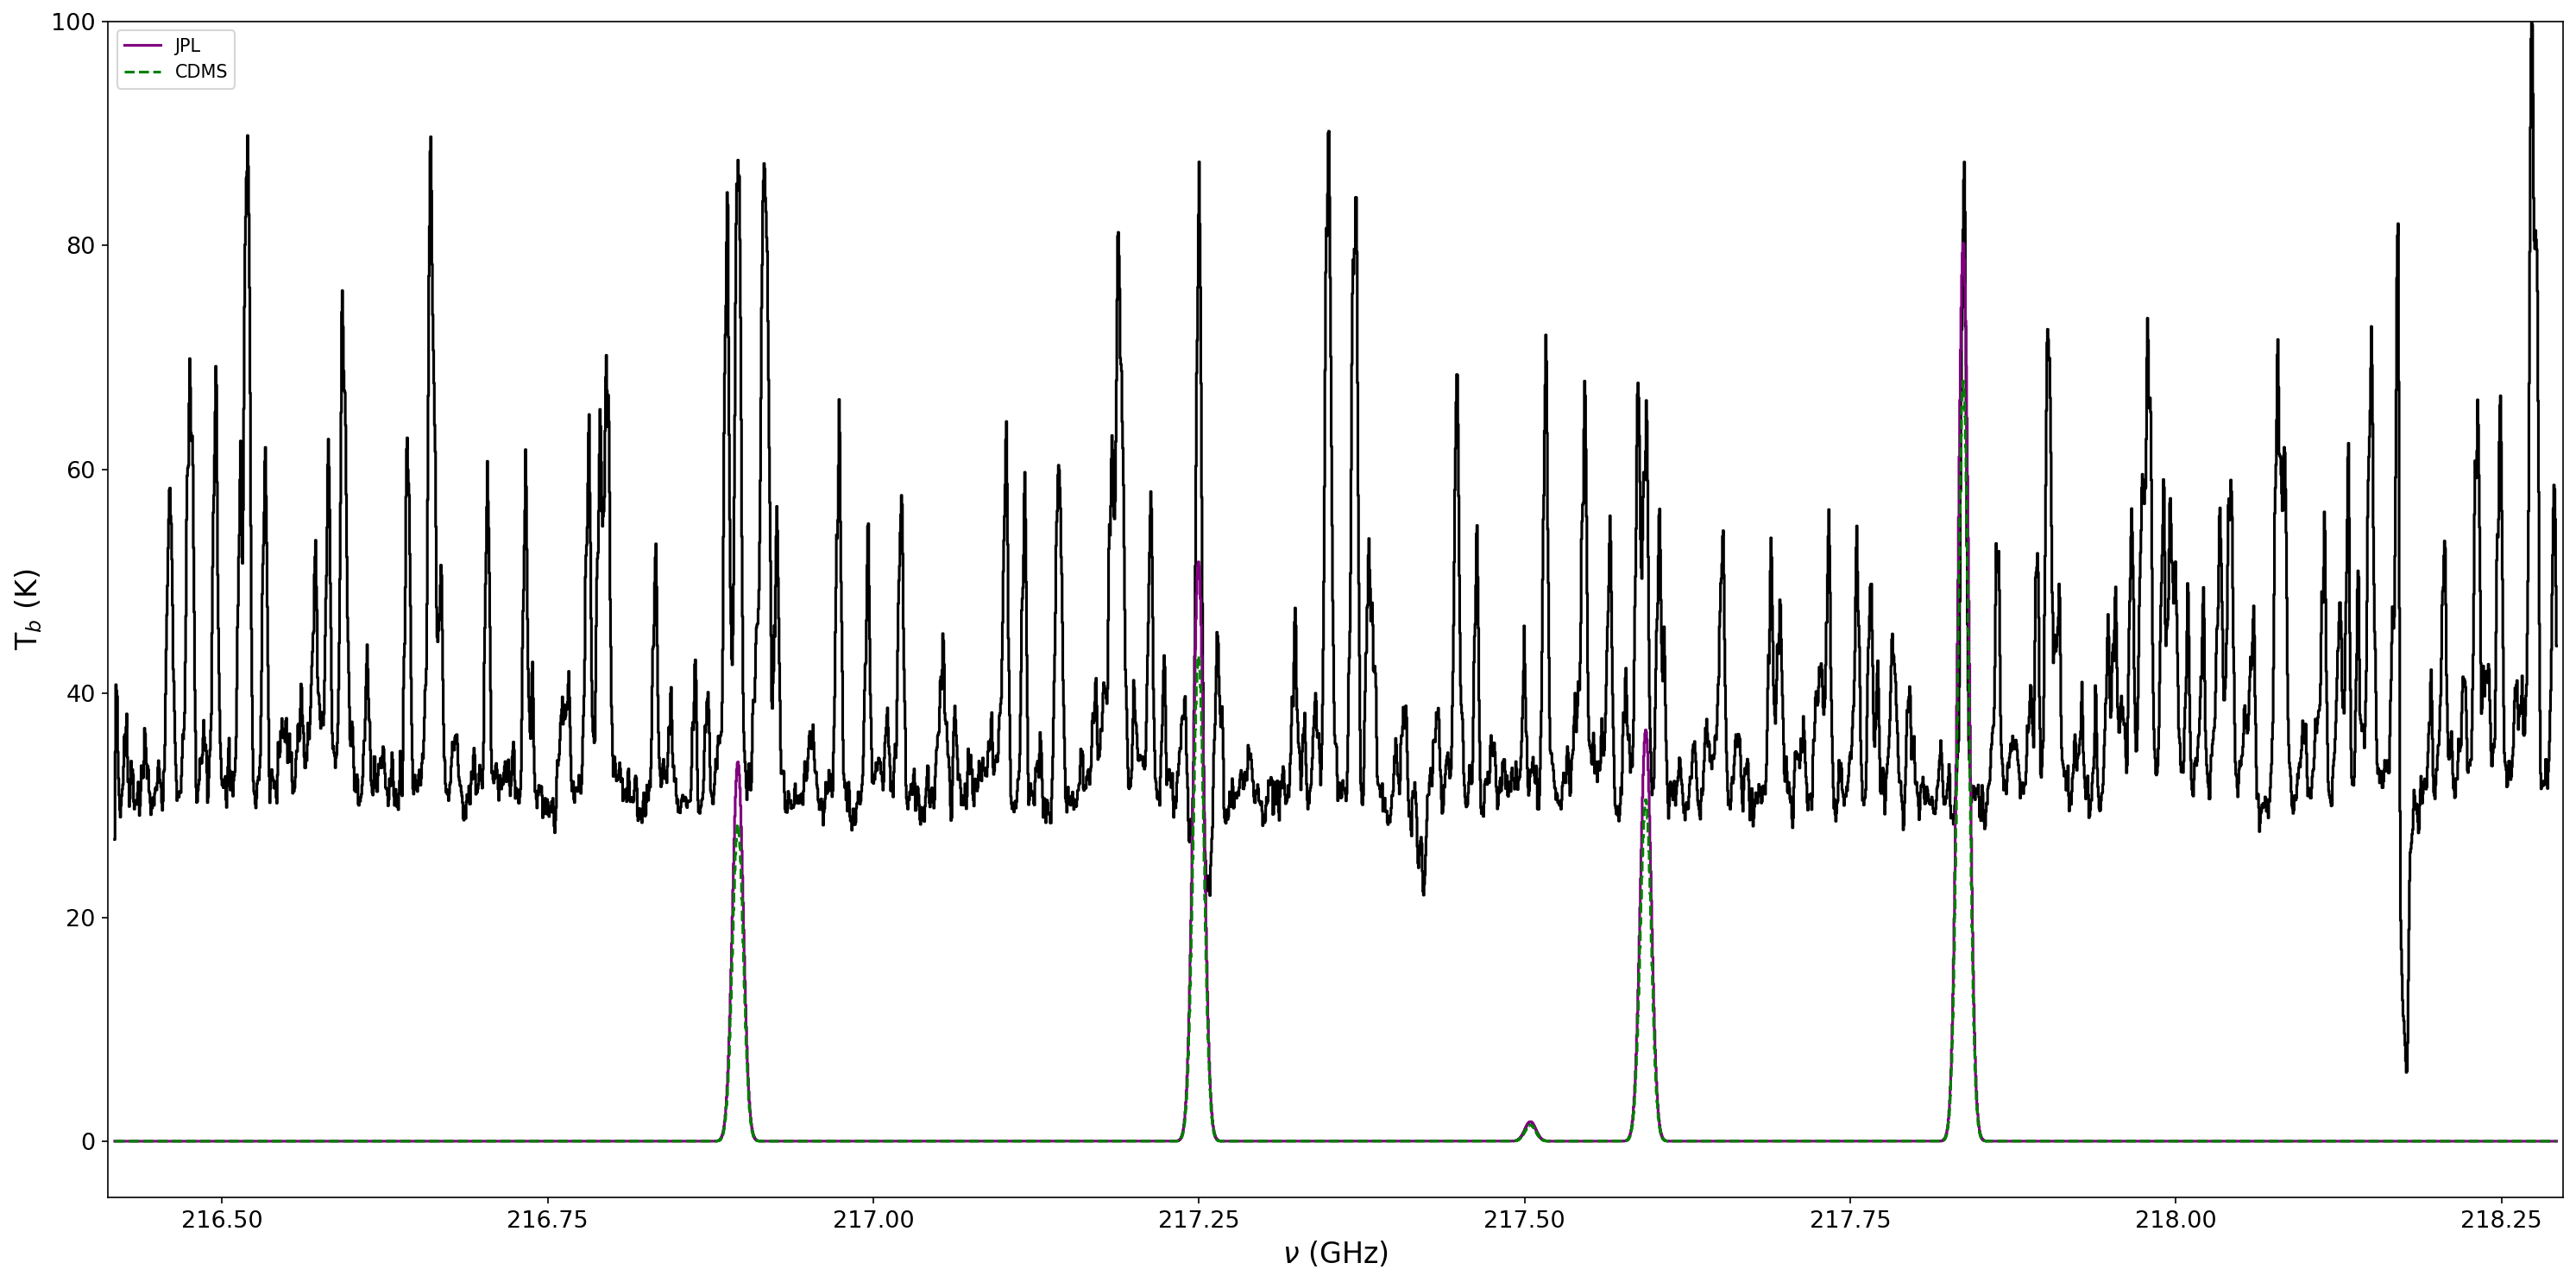

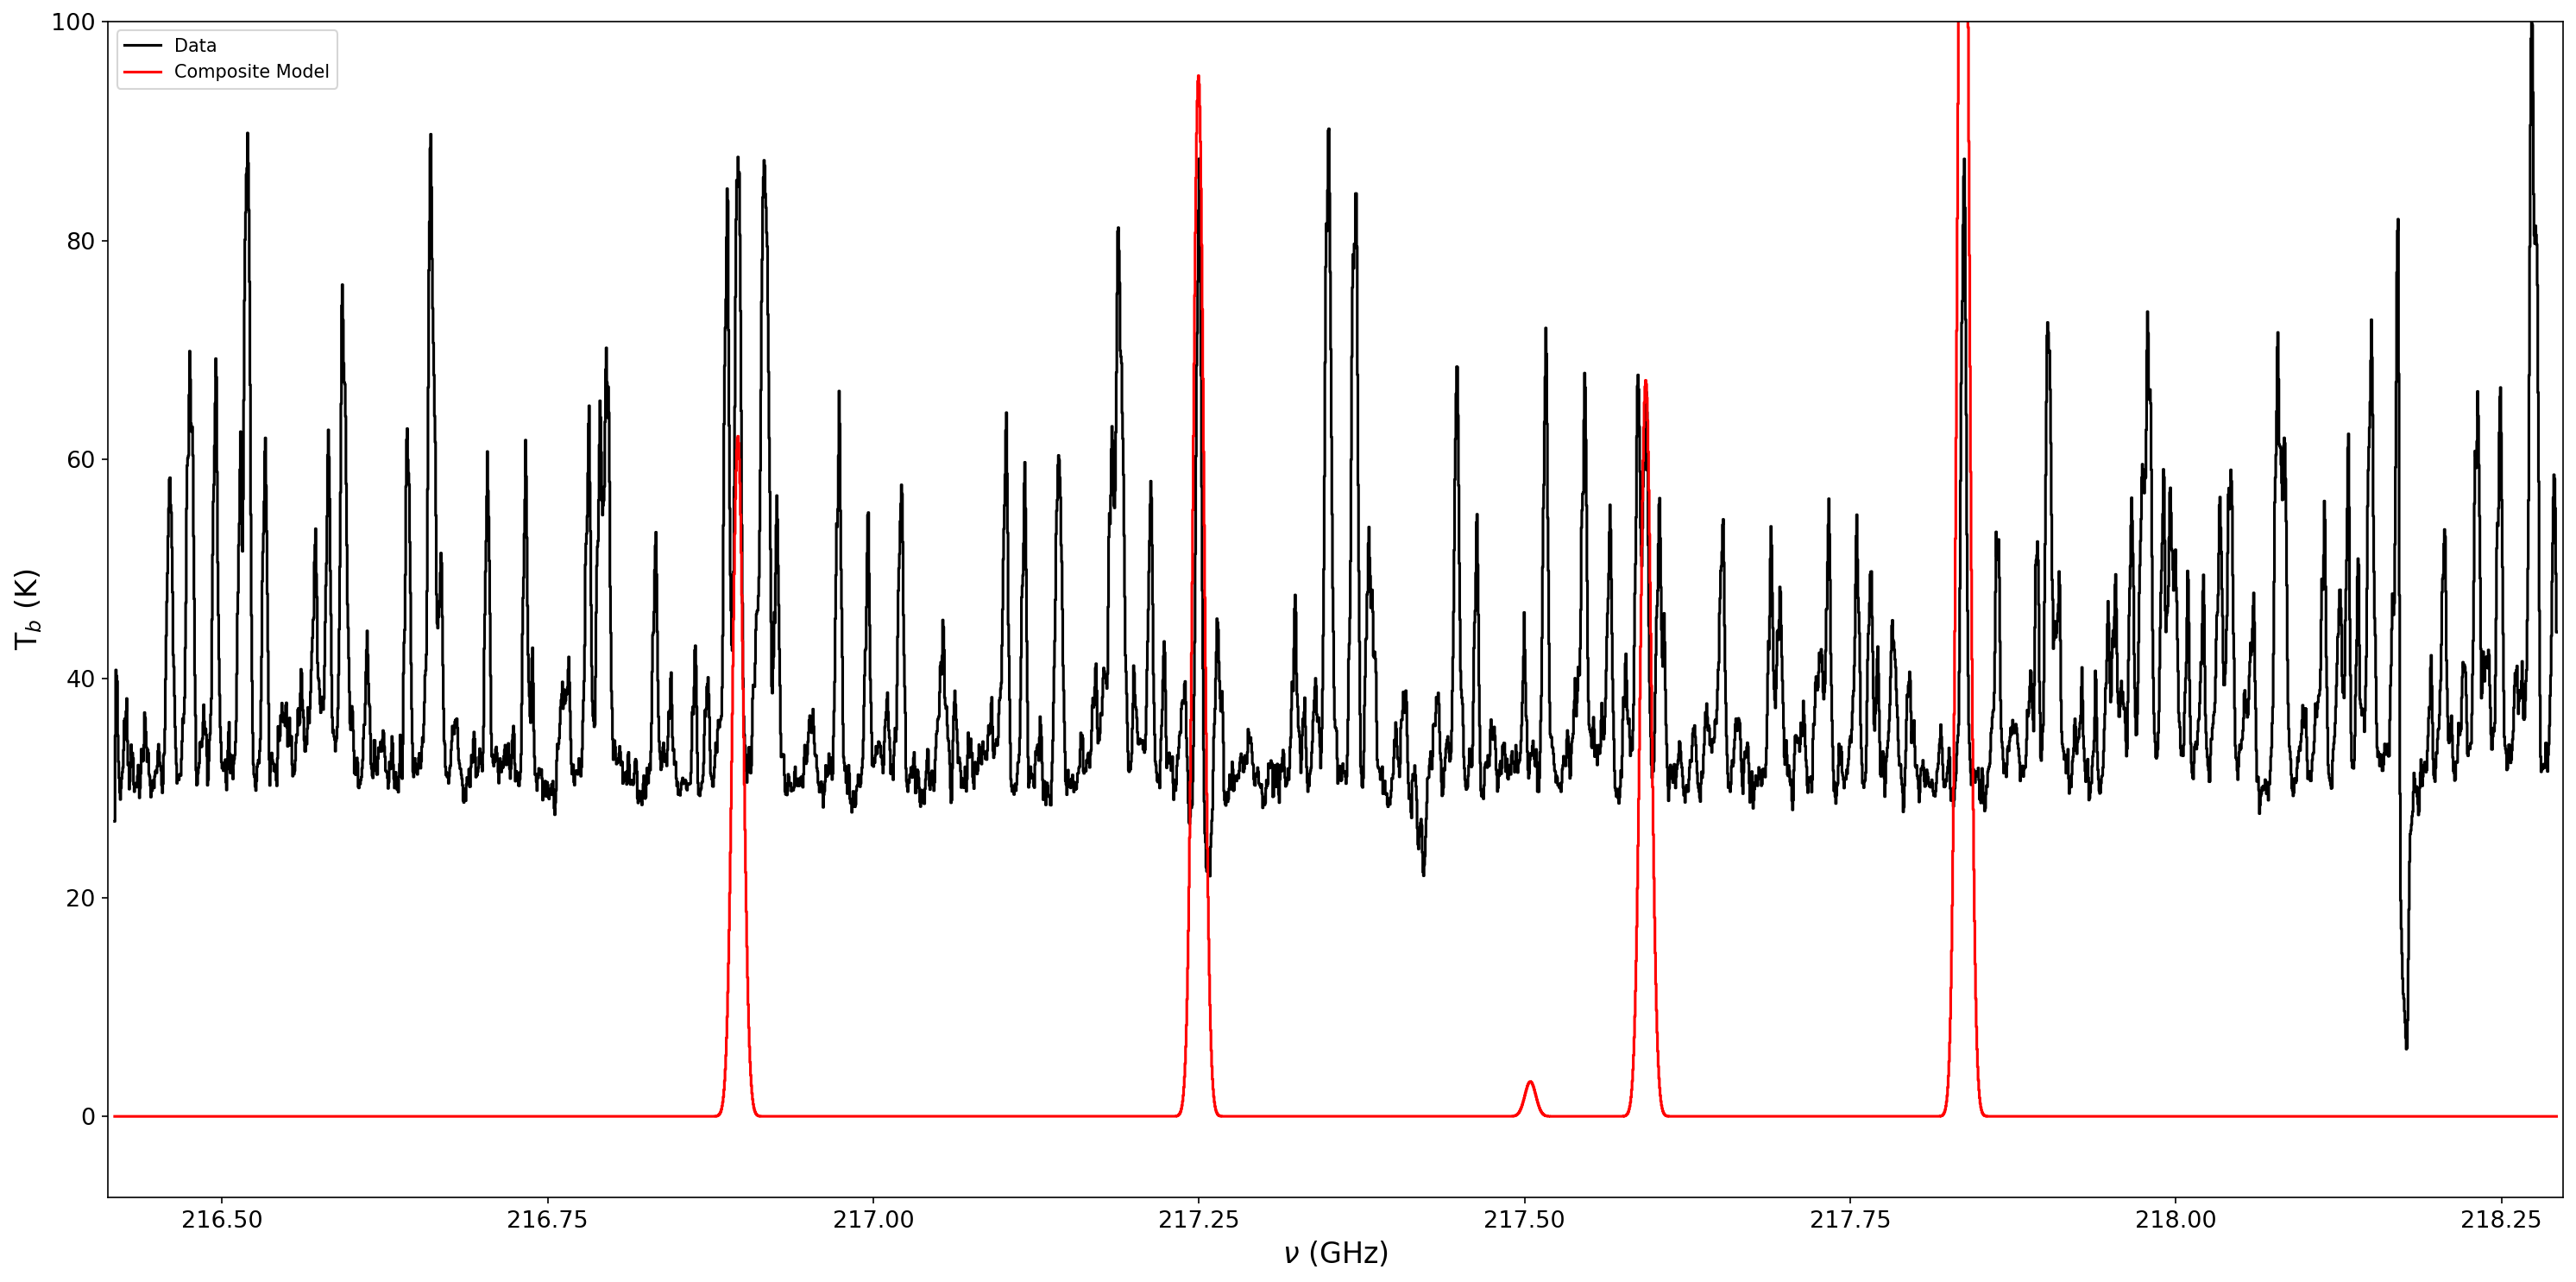

JPL/CDMS brightness ratios[1.19892447 1.1945999  1.20980762 1.20426566 1.20426566 1.1818395 ]
Getting ready - spw1
Corrected decreasing frequency axis
Plotting model spectra
Gathering CDMS table parameters
Begin model loops for JPL CH3OH
Begin CDMS CH3OH modeling

yay


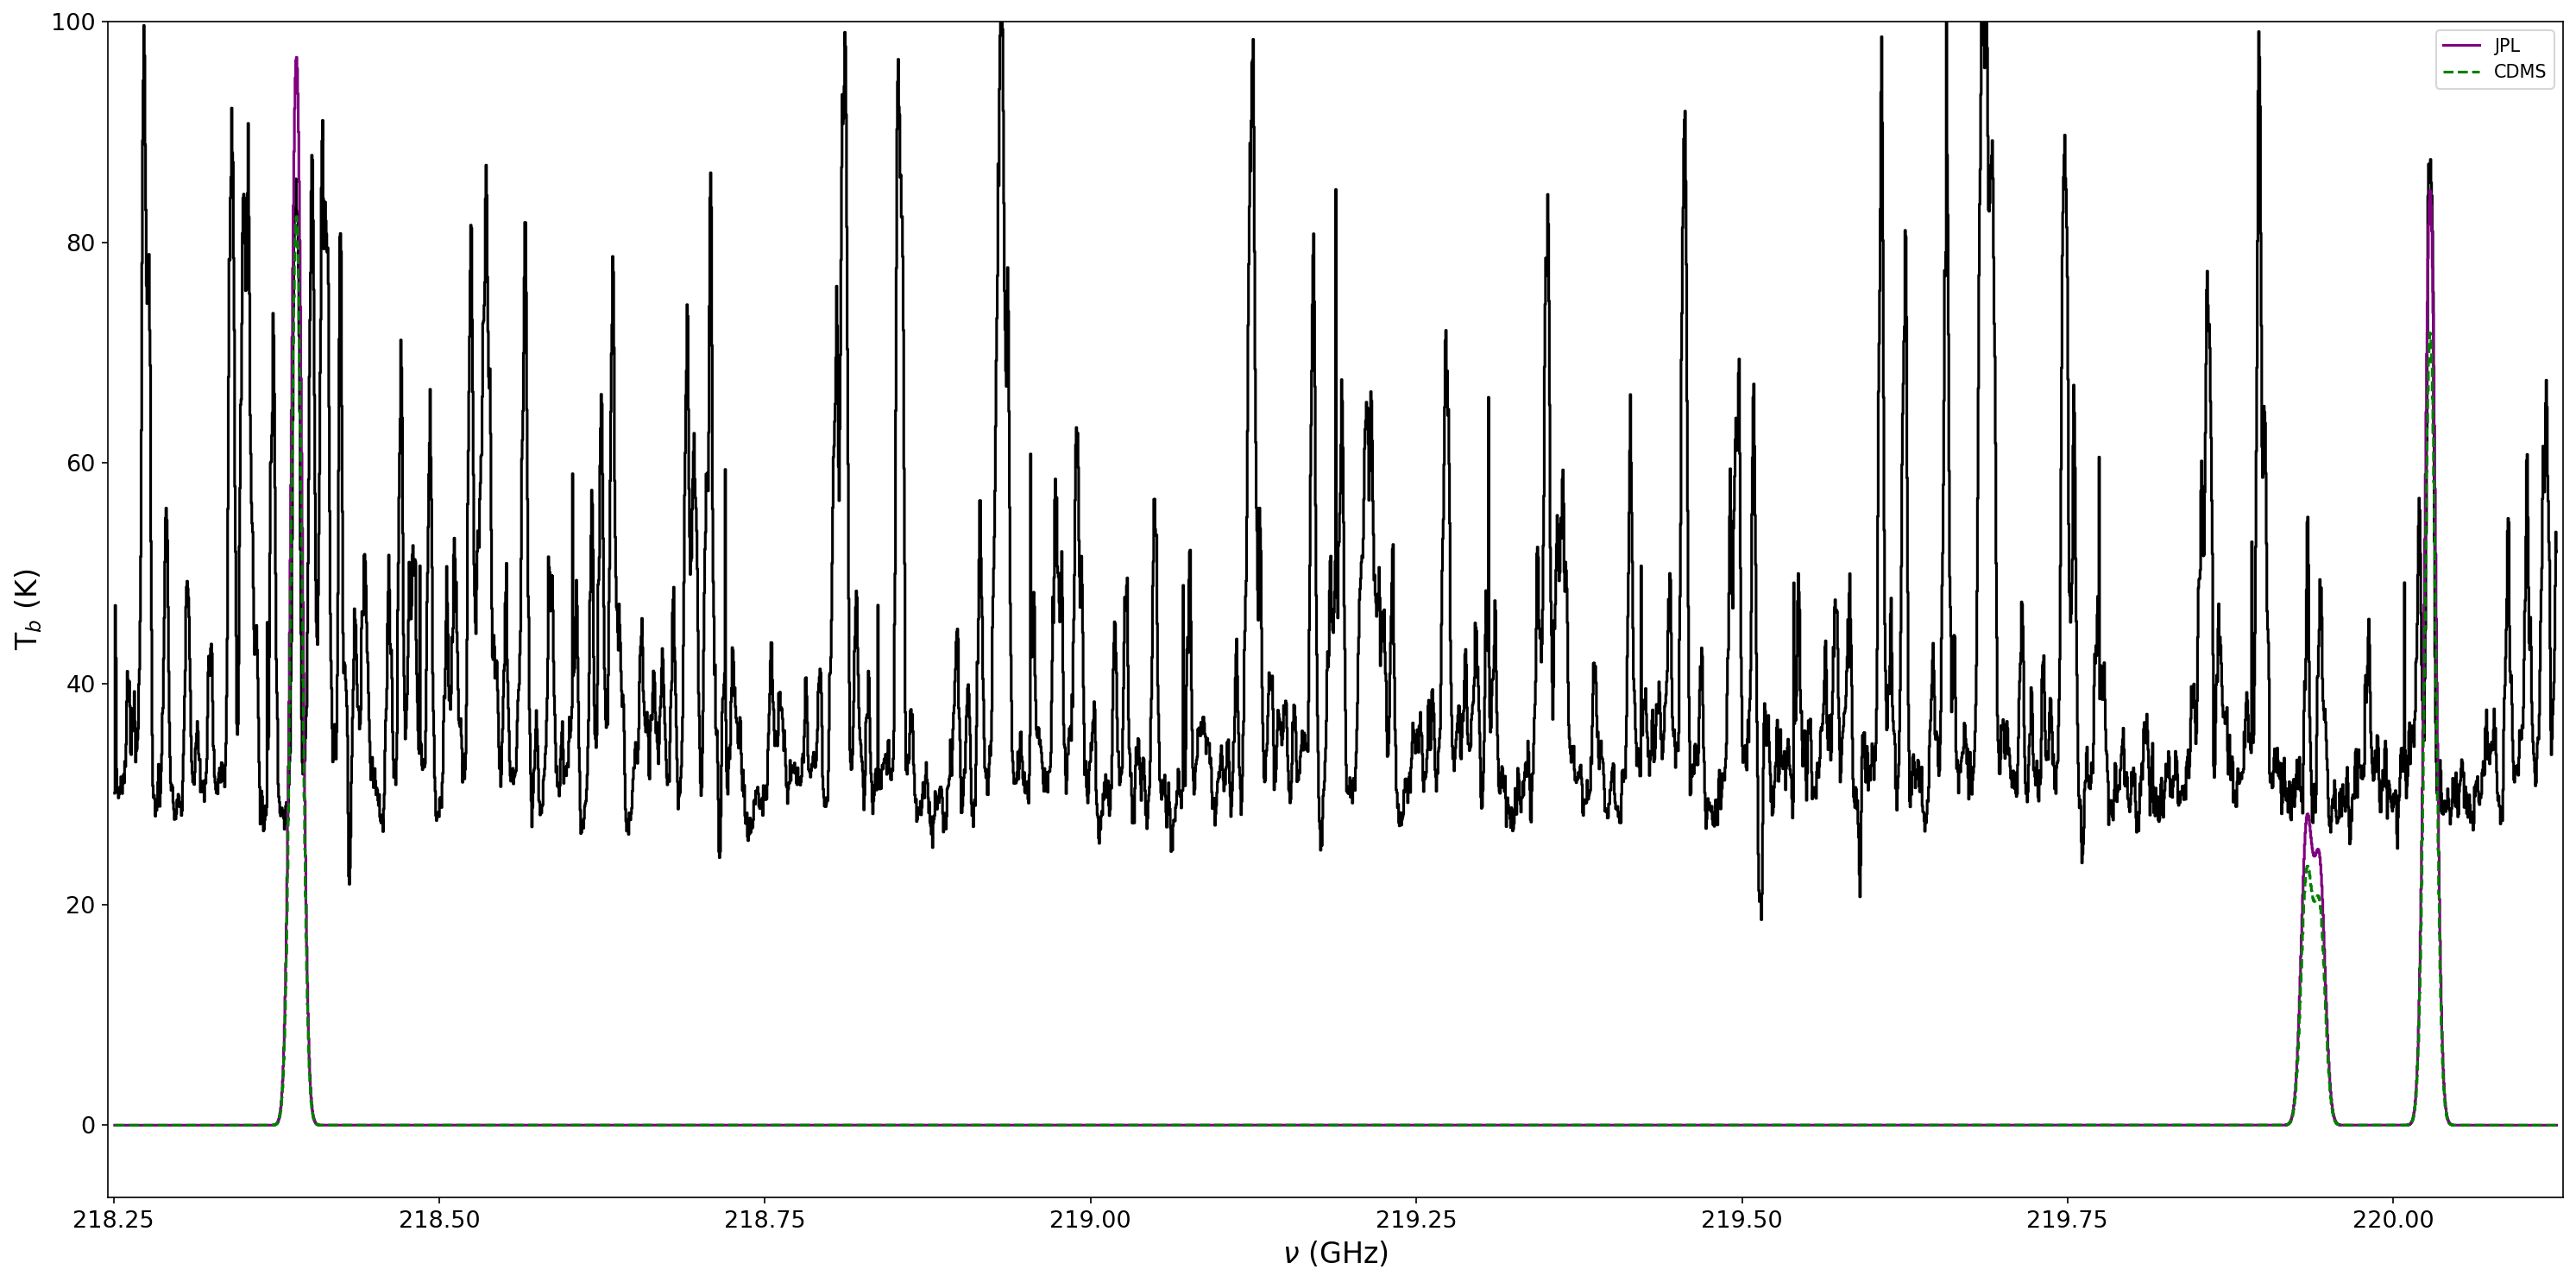

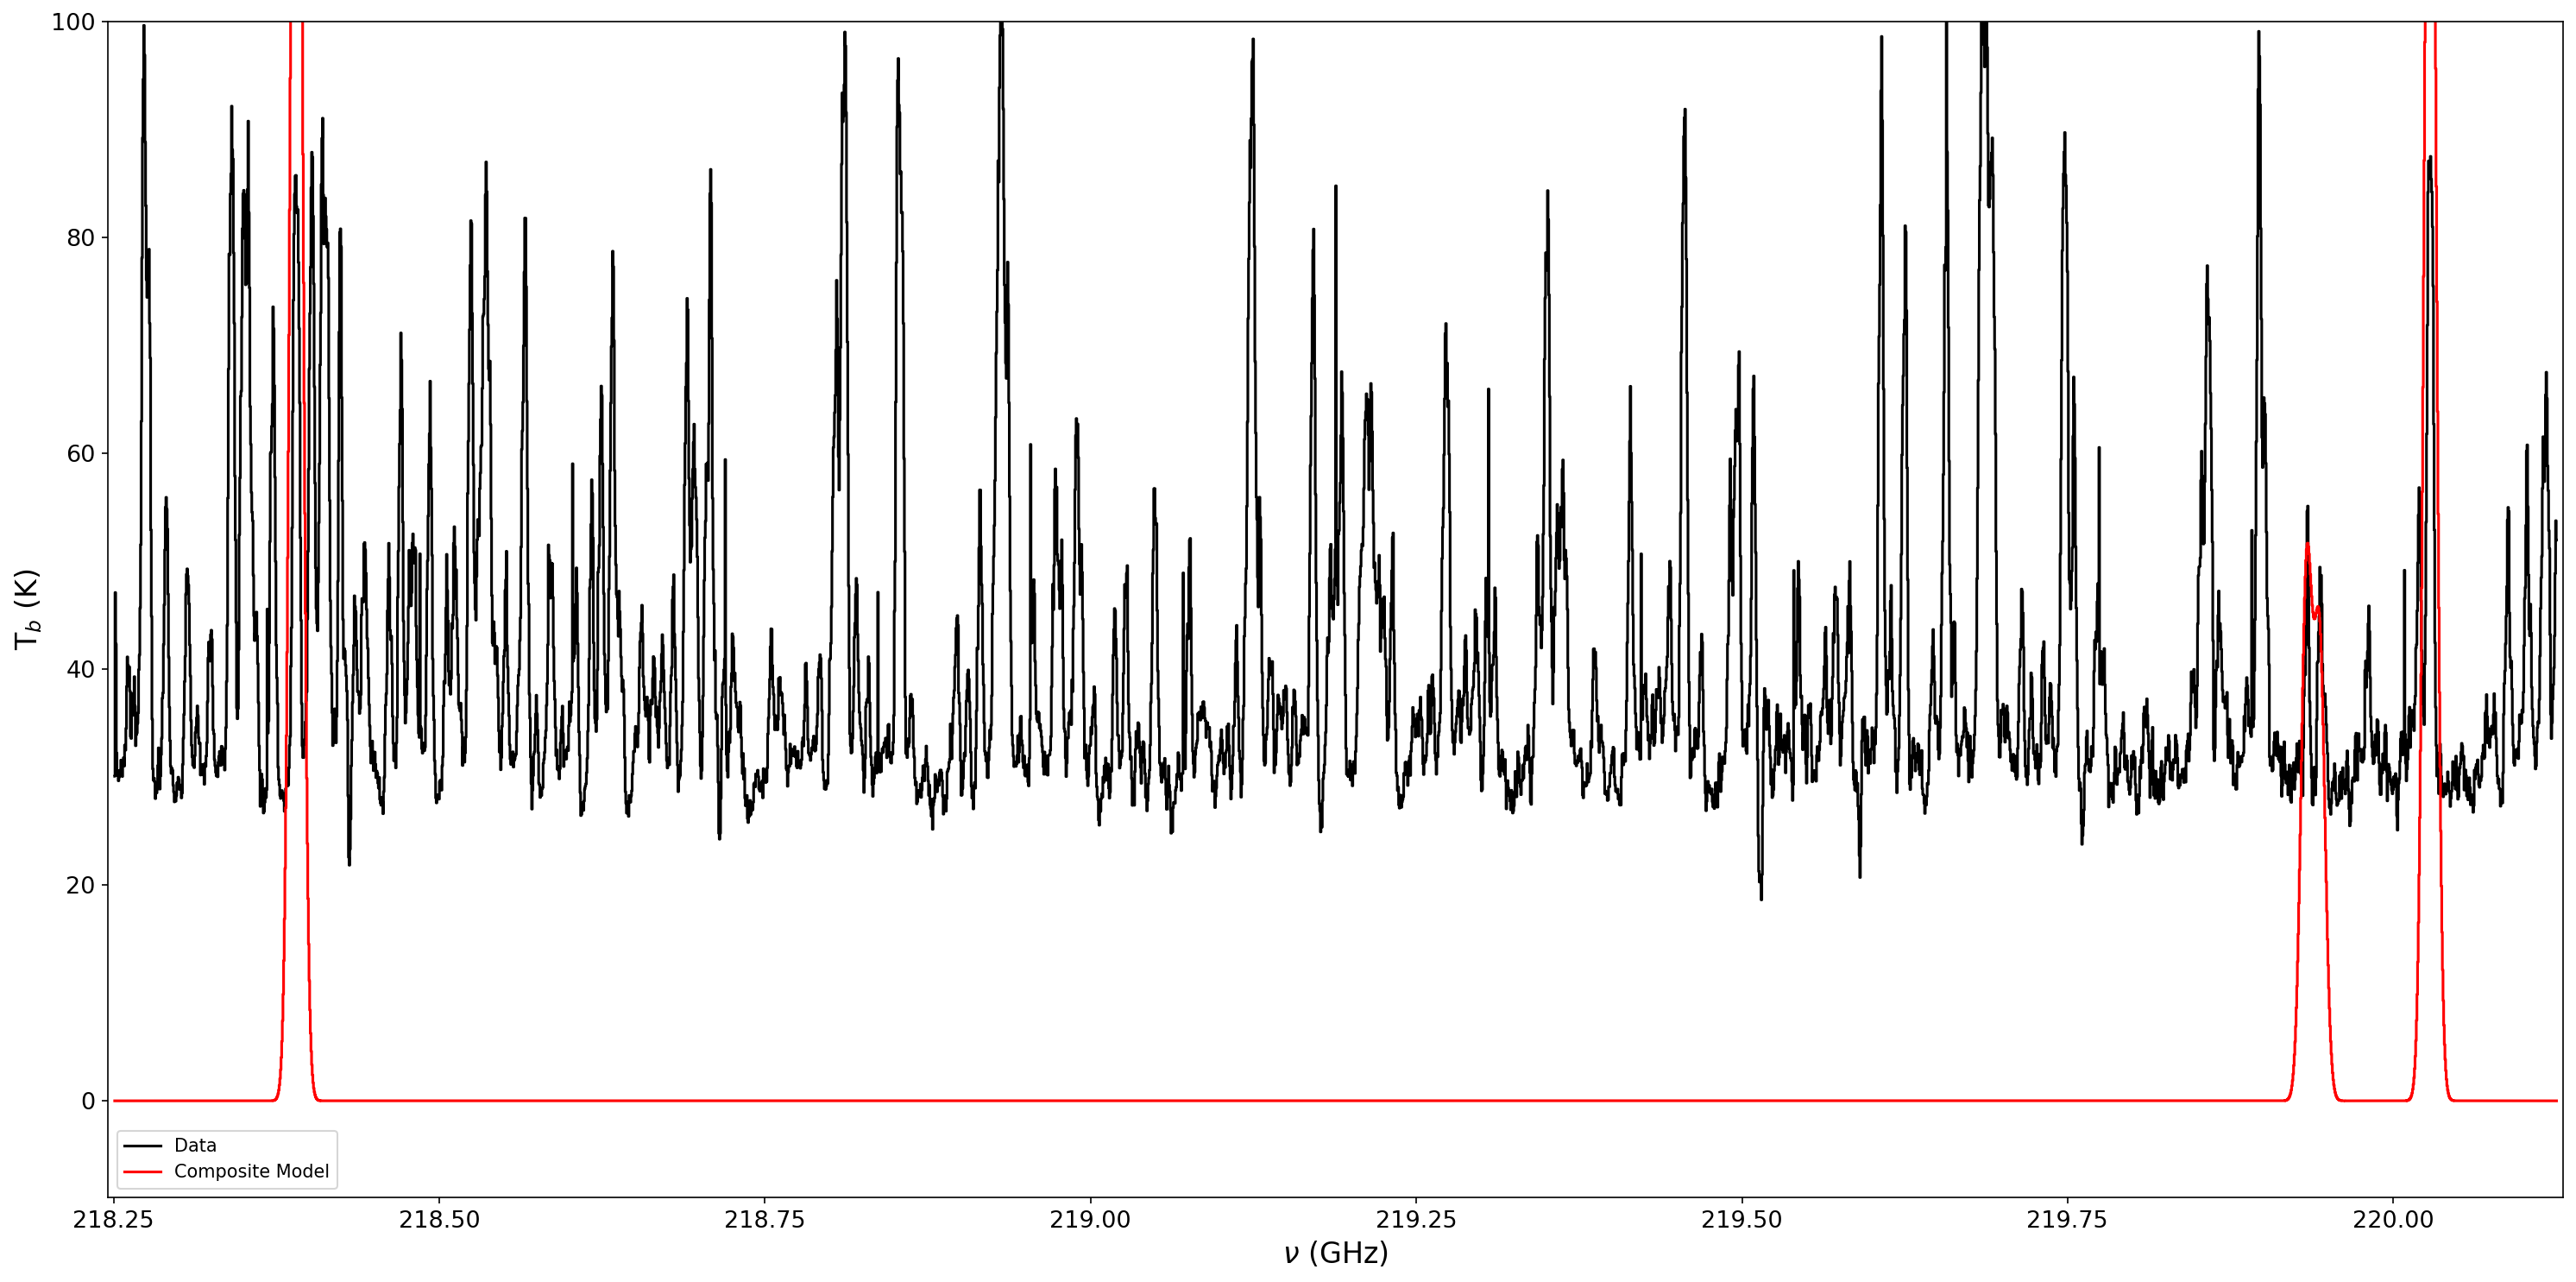

JPL/CDMS brightness ratios[1.17528357 1.20148124 1.2027464  1.17984068]
Getting ready - spw2
Plotting model spectra
Gathering CDMS table parameters
Begin model loops for JPL CH3OH
Begin CDMS CH3OH modeling

yay


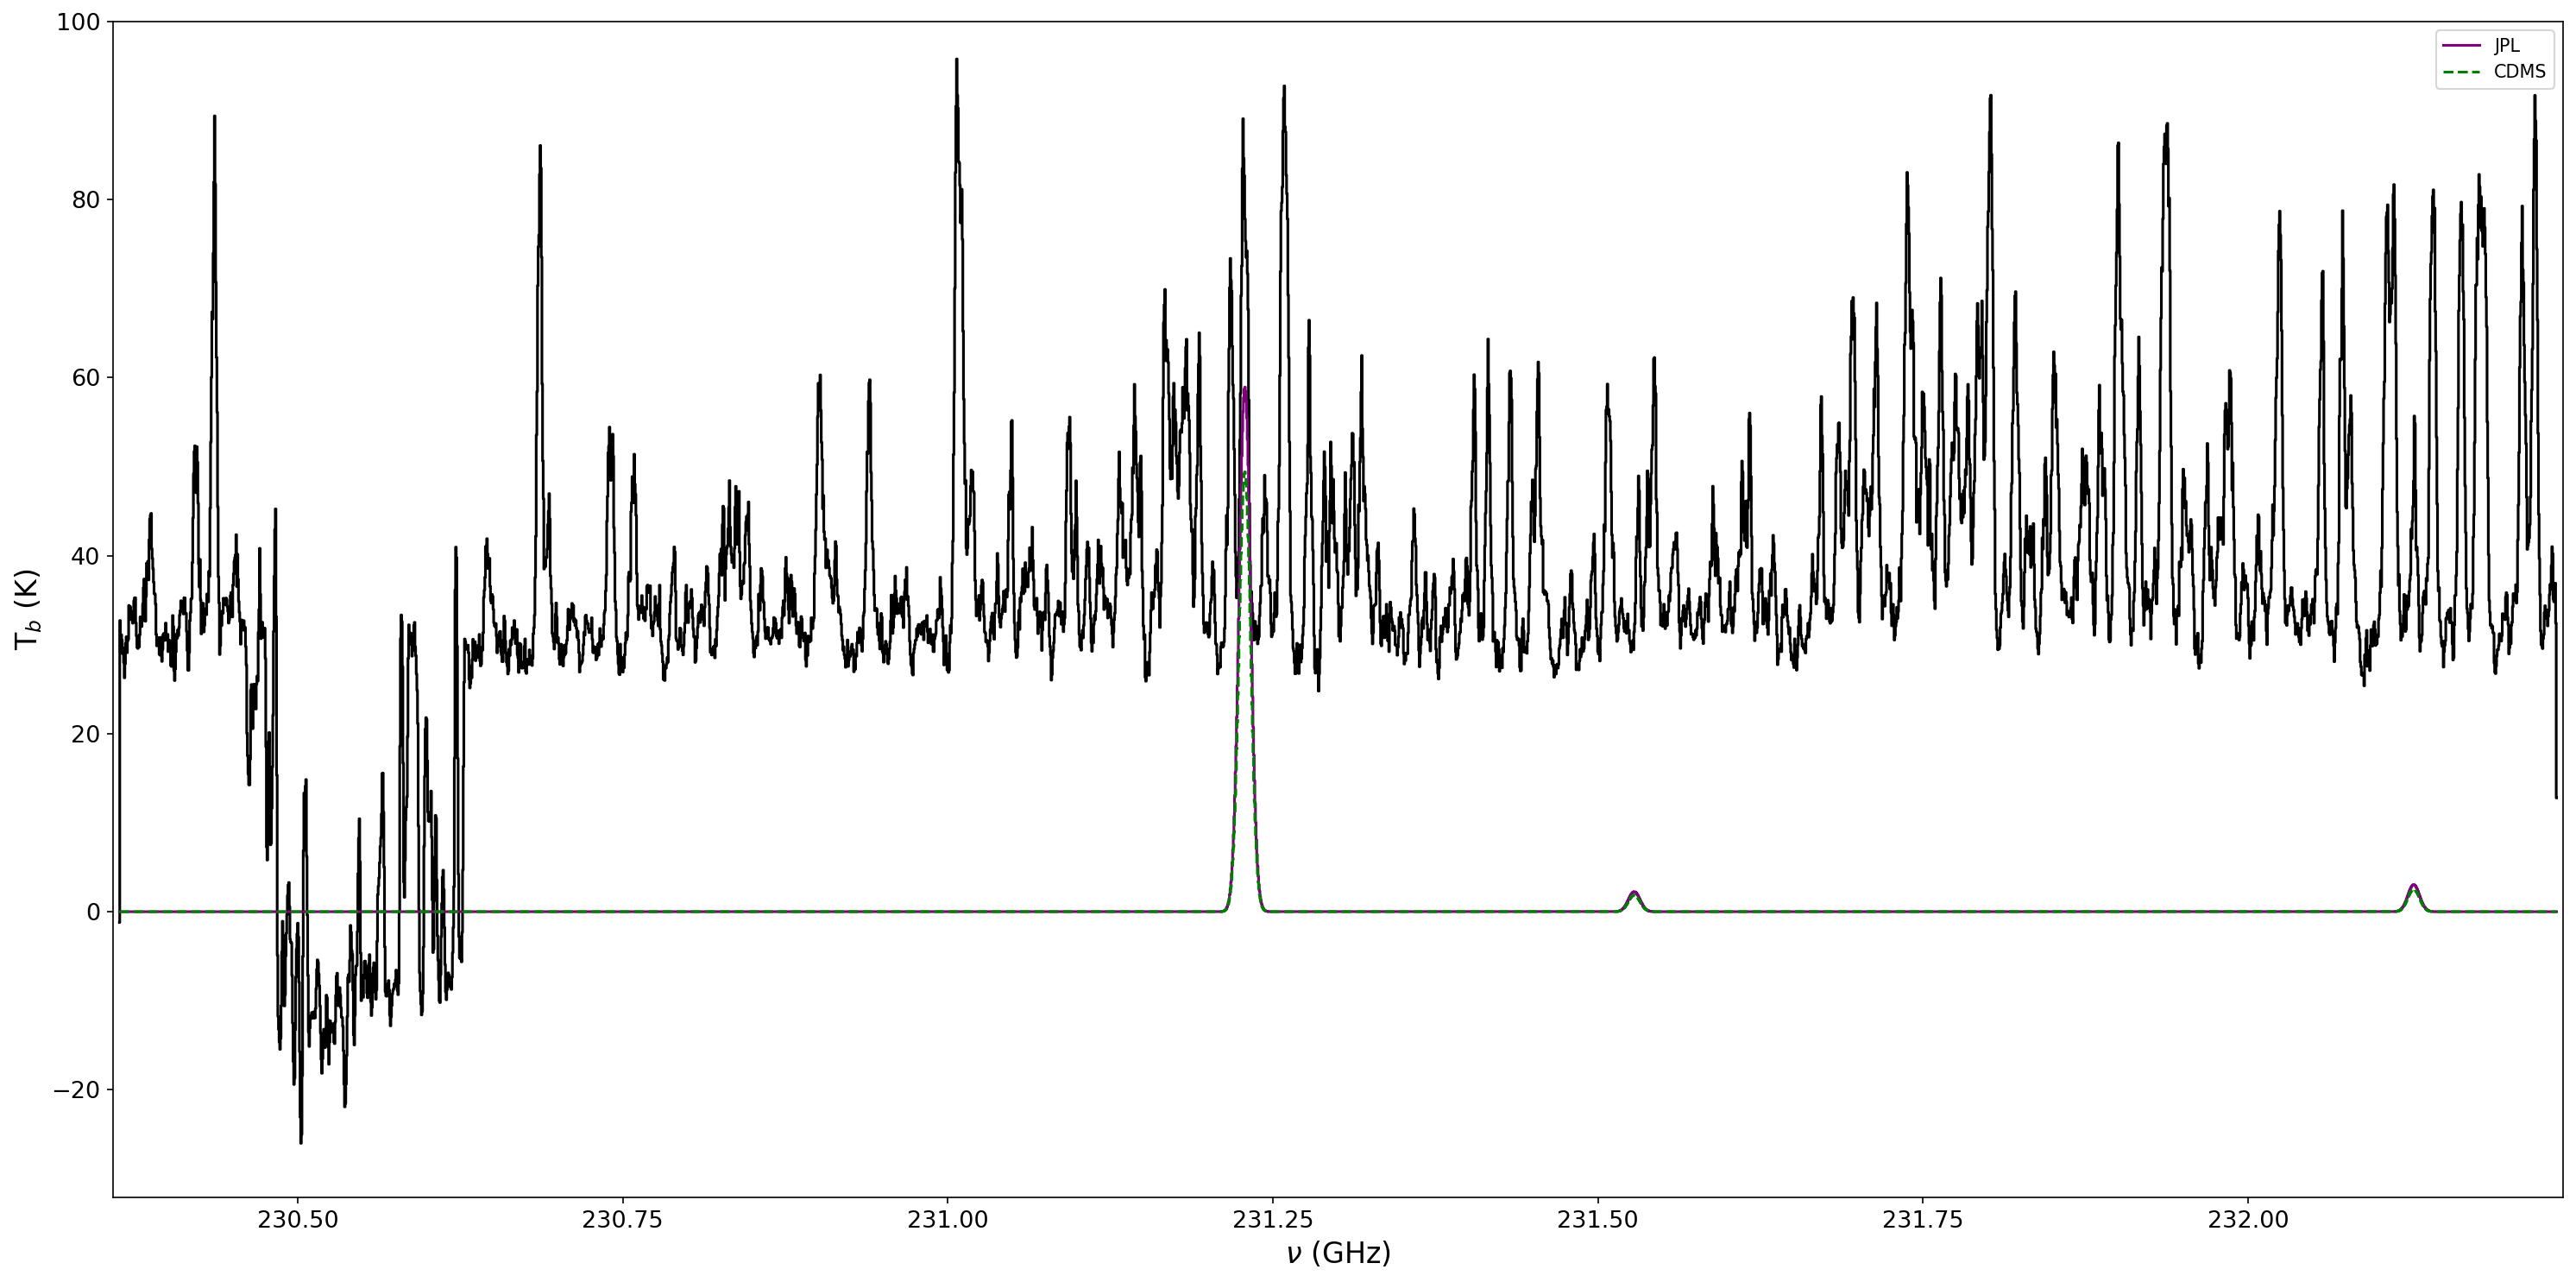

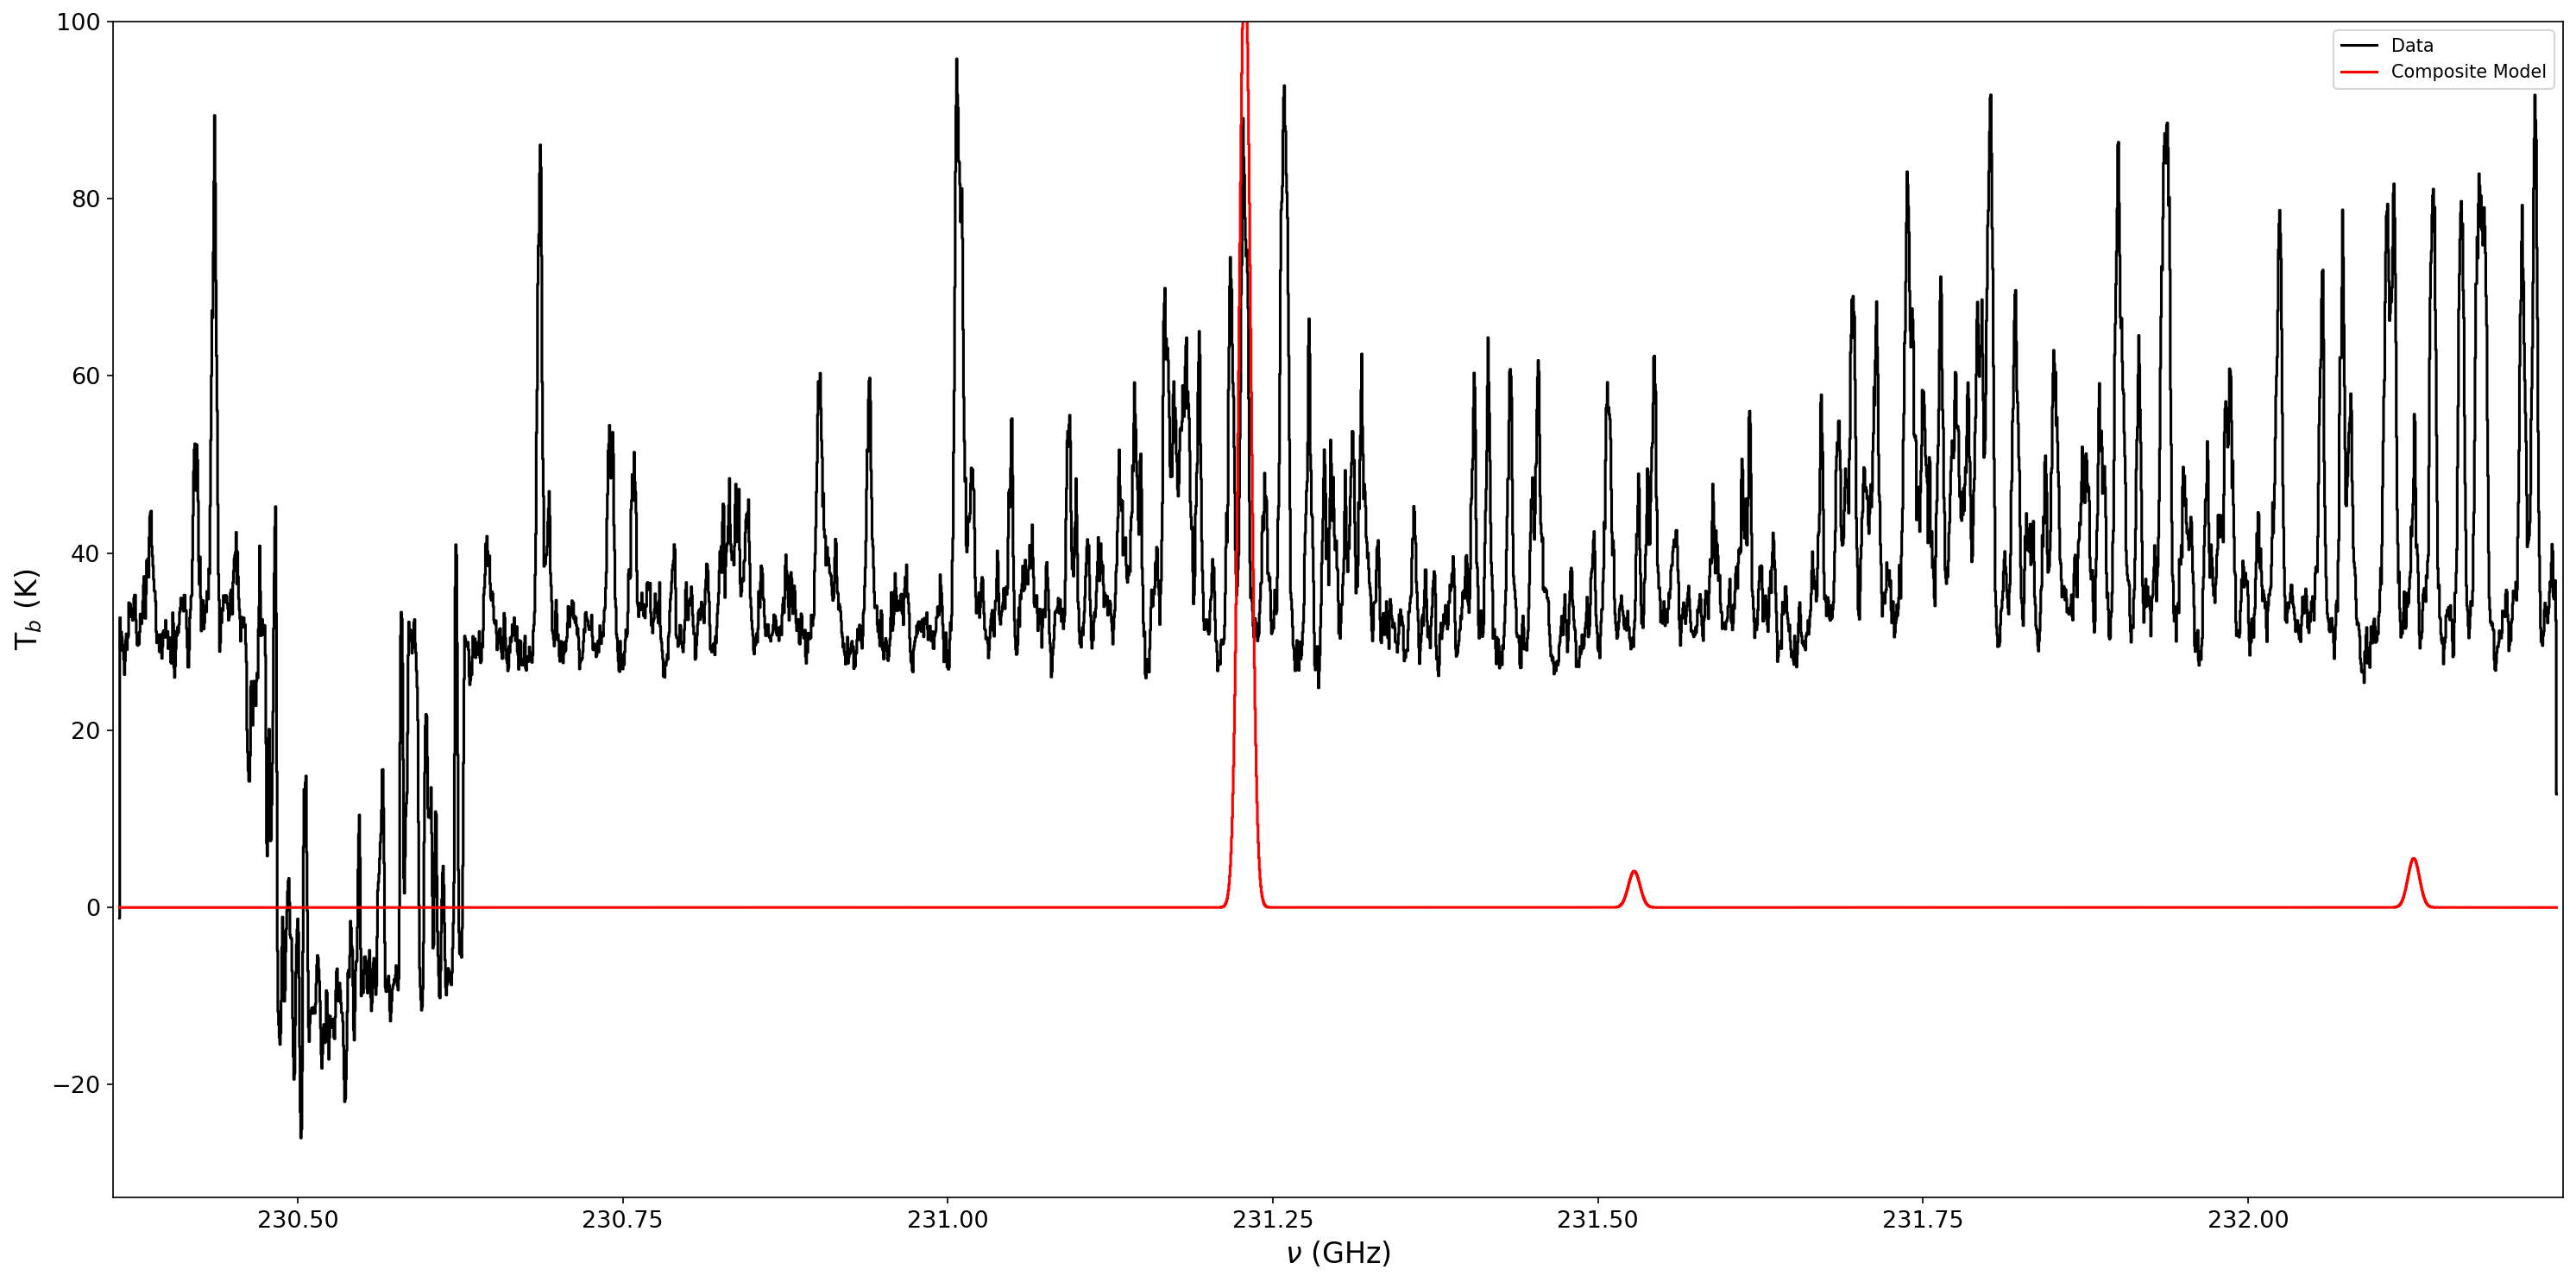

JPL/CDMS brightness ratios[1.19987087 1.19267371 1.20964156 1.20938336]
Getting ready - spw3
Plotting model spectra
Gathering CDMS table parameters
Begin model loops for JPL CH3OH
Begin CDMS CH3OH modeling

yay


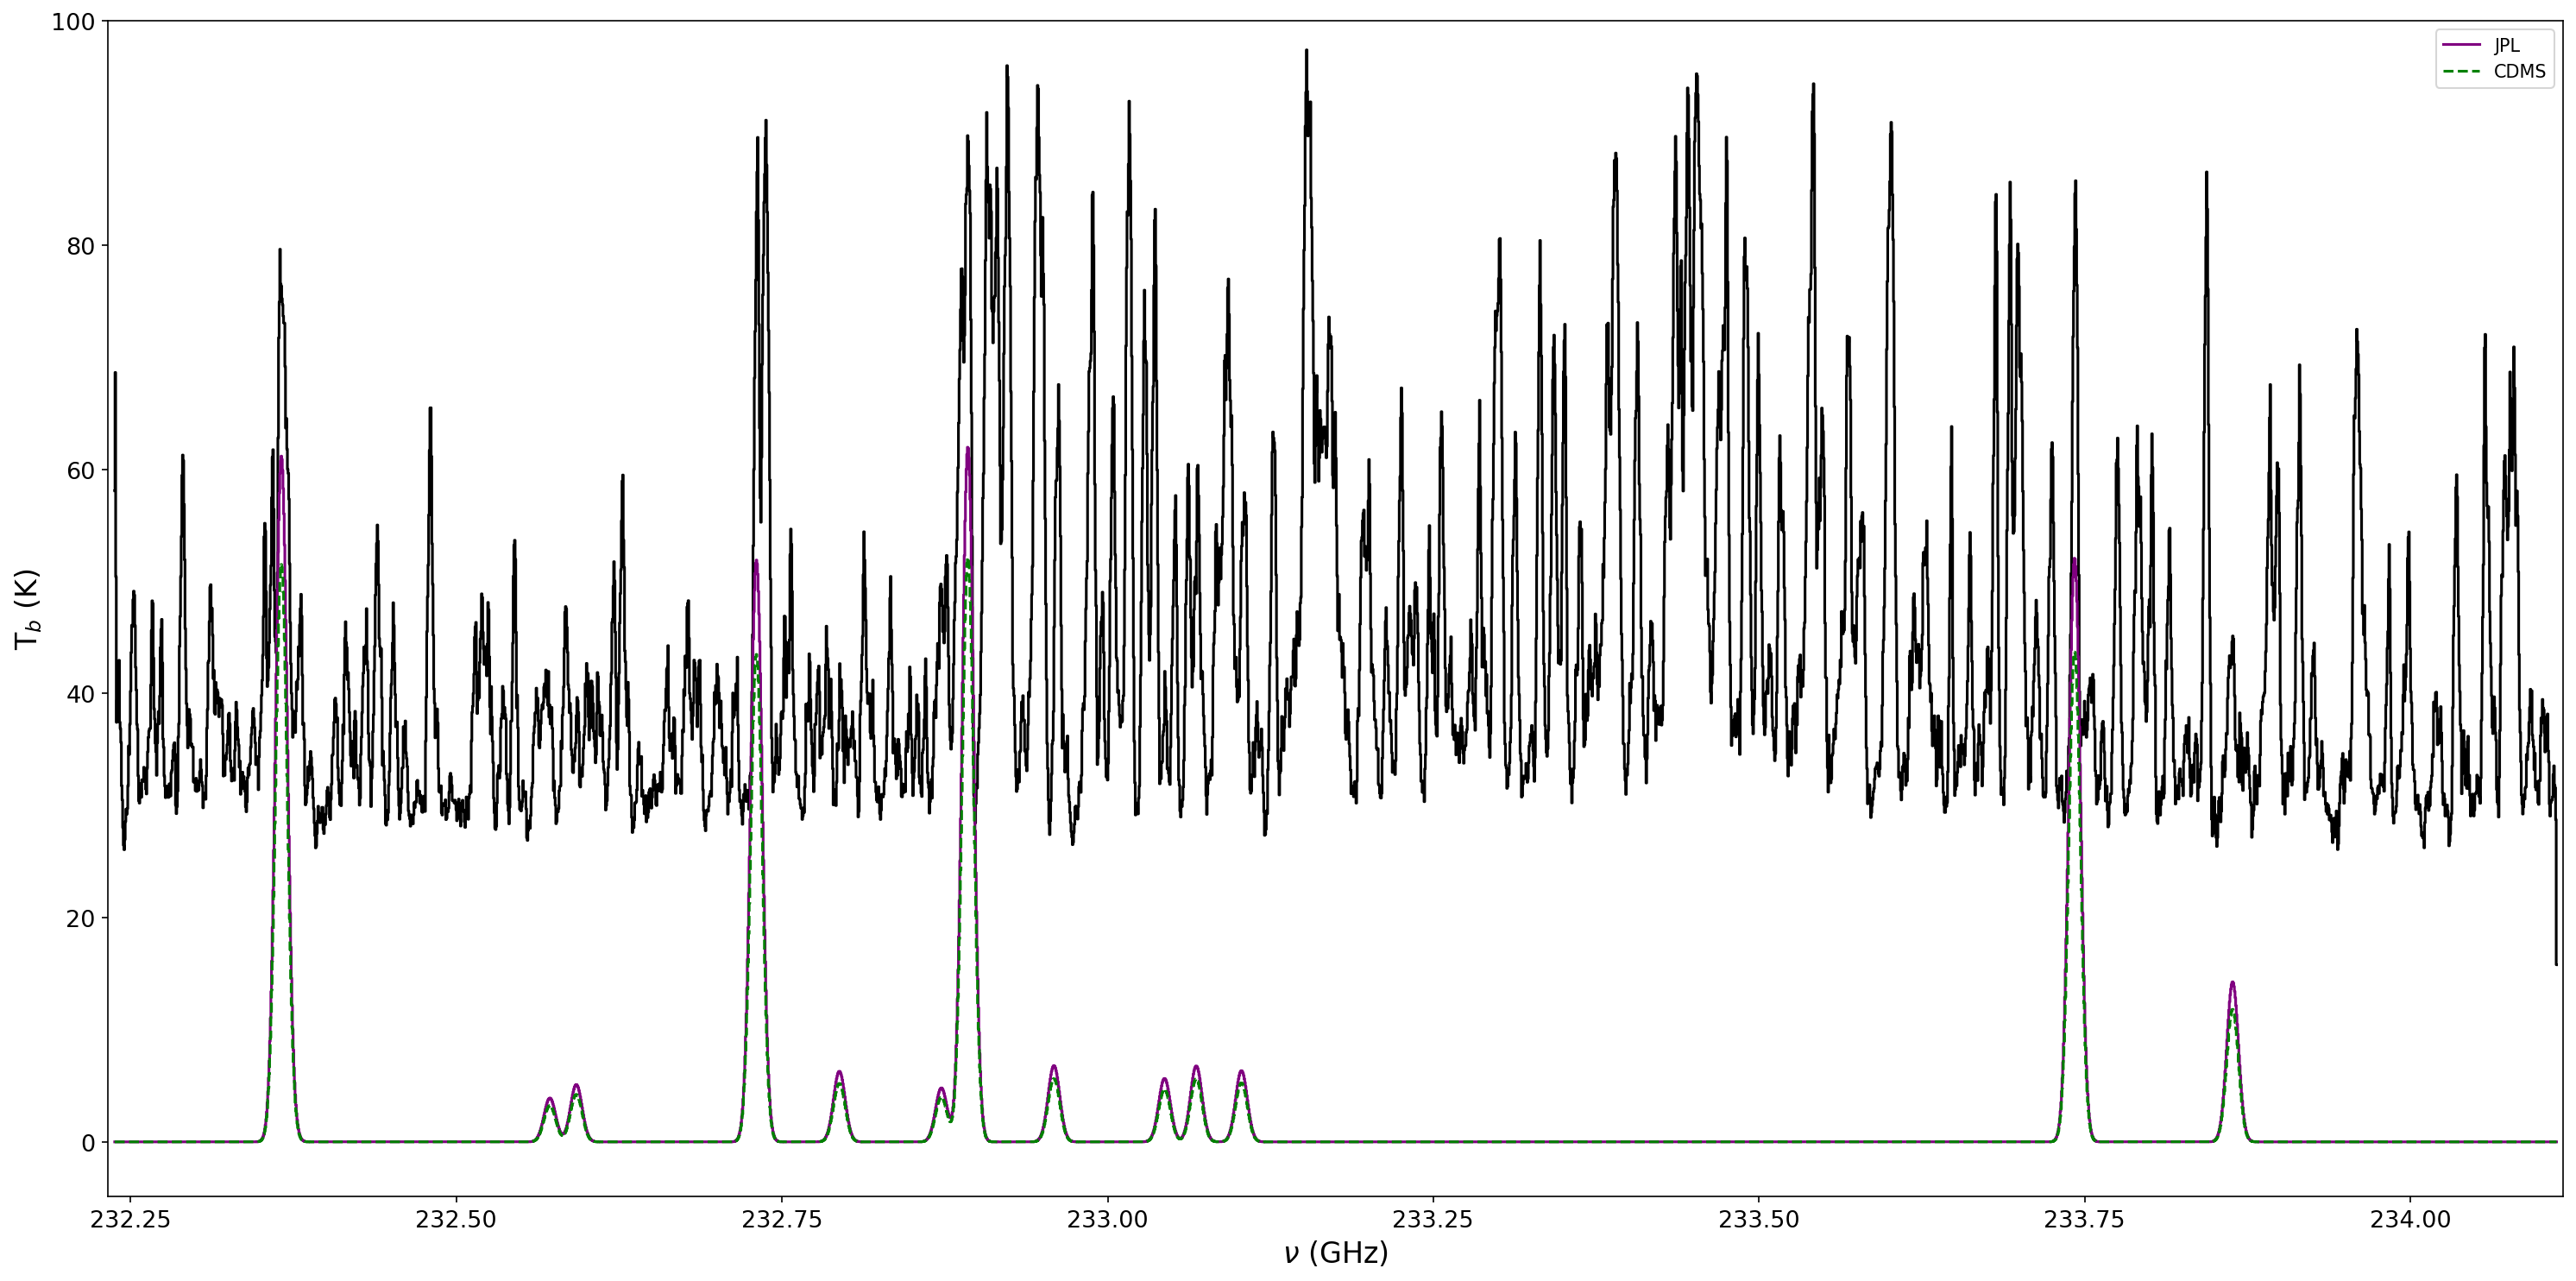

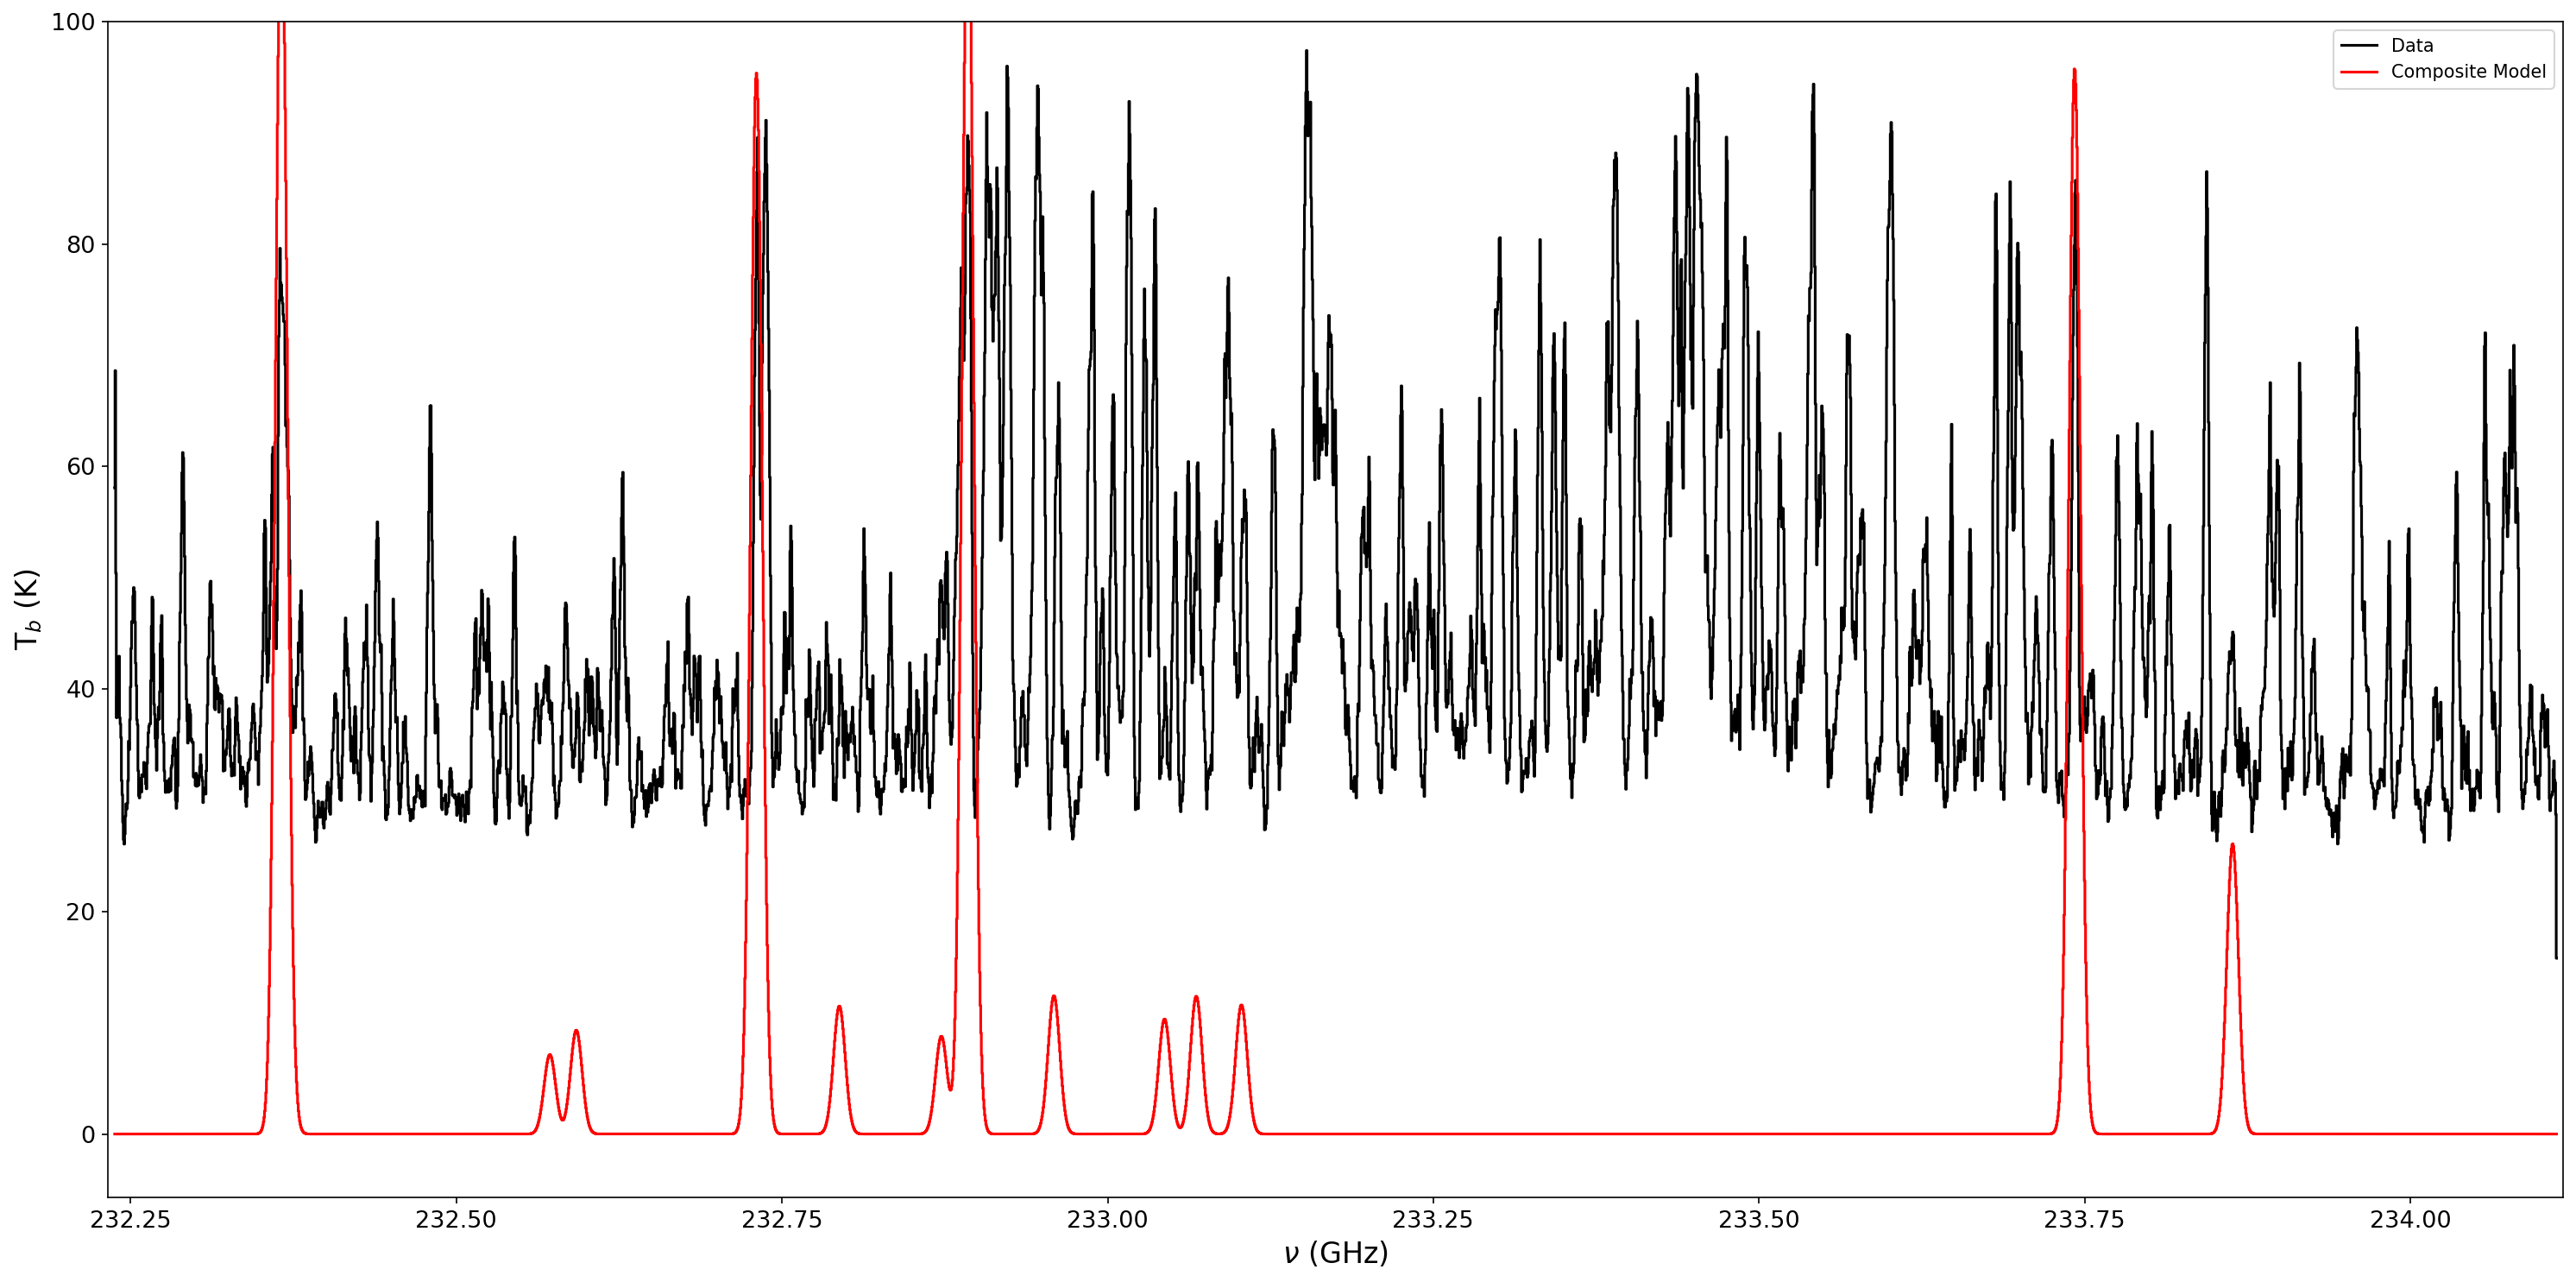

JPL/CDMS brightness ratios[1.18704394 1.20936751 1.20937258 1.20897519 1.19350653 1.20830657
 1.20907428 1.18876441 1.20813828 1.20851693 1.20814613 1.20856201
 1.19139006 1.20802616 1.20802616]


In [3]:
run testcdmsvsjpl.py

In [31]:
linedetections[' CH3OH '].values()

dict_values([[True, <Quantity 49.86325628 K>], [True, <Quantity 2.54786828 K>], [True, <Quantity 3.23047958 K>], [True, <Quantity 4.22507449 K>], False, [True, <Quantity 43.47670643 K>], [True, <Quantity 5.20809458 K>], False, [True, <Quantity 3.97765118 K>], [True, <Quantity 52.15419553 K>], False, [True, <Quantity 5.62930995 K>], [True, <Quantity 4.68205315 K>], [True, <Quantity 5.60939624 K>], [True, <Quantity 5.25802181 K>], False, [True, <Quantity 43.72730843 K>], [True, <Quantity 5.9091649 K>], [True, <Quantity 5.90916317 K>], False])

Spectra and stds are sequential order
Absolute model line width: 4.741319293560374 km / s

Getting ready - spw0
Corrected decreasing frequency axis
Plotting model spectra
Gathering CDMS table parameters
Begin model loops for  CH3OCHO 
Begin model loops for  CH3CHO 
    FREQ     ERR    LGINT   DR    ELO    GUP ... F1l F2l F3l    name     Lab 
    MHz      MHz   MHz nm2       1 / cm      ...                             
----------- ------ ------- --- --------- --- ... --- --- --- ---------- -----
 216476.453 0.2262 -7.4658   3 1318.3074 131 ...   2  --  -- C2H5OH,v=0 False
216480.3452 0.0057 -6.3065   3  264.8901  55 ...   0  --  -- C2H5OH,v=0 False
216496.5719 0.0256 -6.5237   3  799.5425  77 ...   1  --  -- C2H5OH,v=0 False
216496.5719 0.0256 -6.5237   3  799.5425  77 ...   1  --  -- C2H5OH,v=0 False
216502.7336  34.98 -7.4872   3  1603.201 135 ...   2  --  -- C2H5OH,v=0 False
216502.7337  34.98 -7.4872   3  1603.201 135 ...   2  --  -- C2H5OH,v=0 False
216521.6912 0.0052 -4.5907   3  

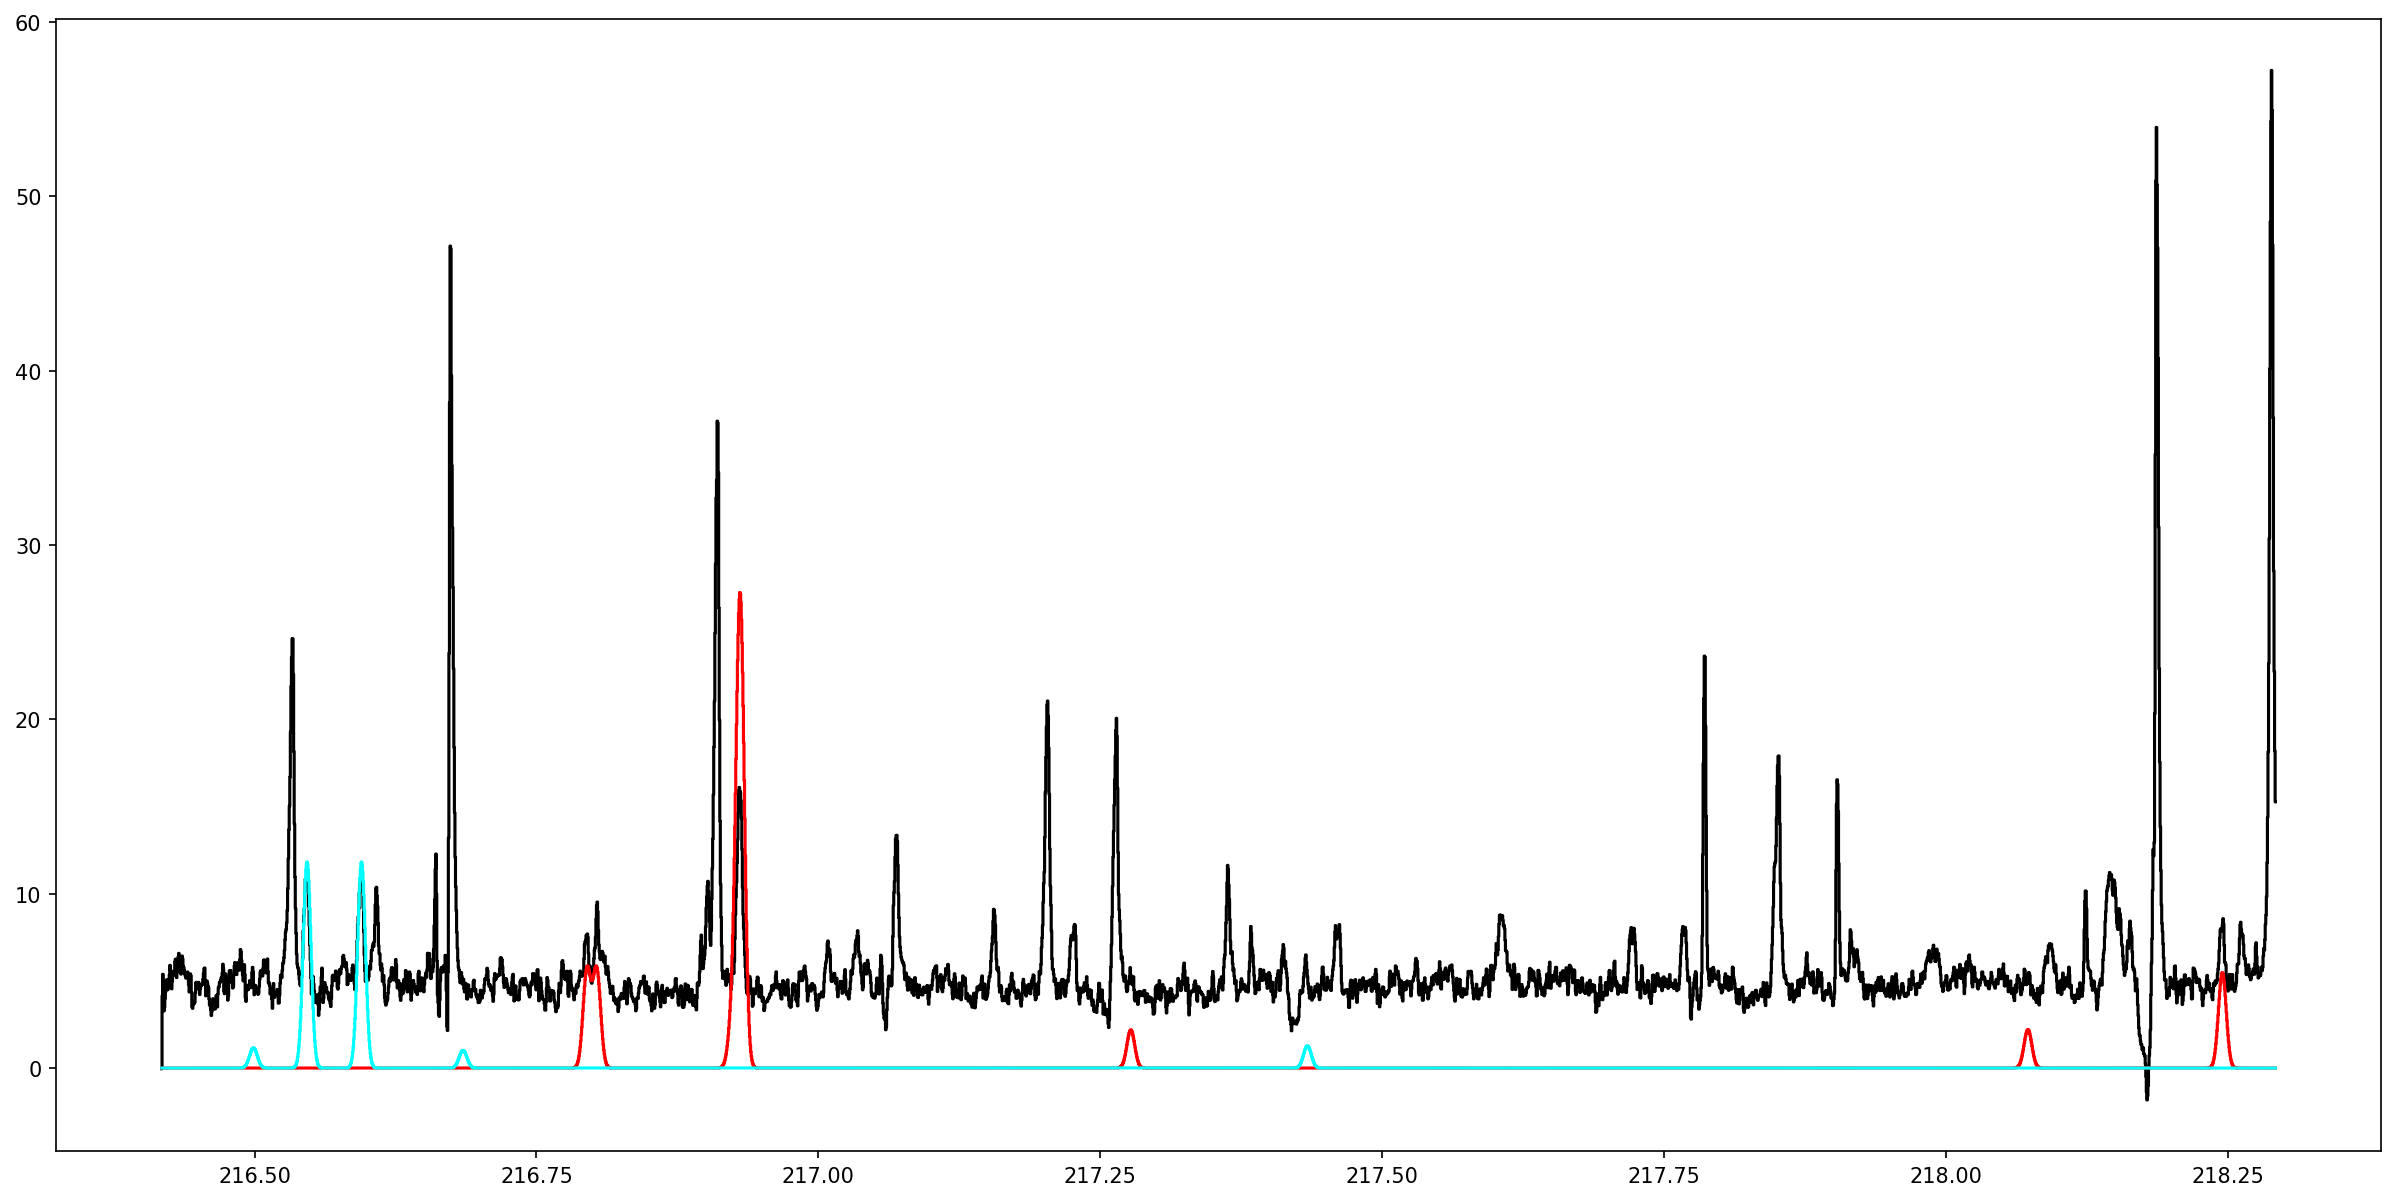

In [2]:
run new_makesyntheticspectra_composite.py

In [3]:
species_table[0:15]

<Table length=15>
    FREQ      ERR    LGINT    DR     ELO    ...  F2l   F3l     name     Lab 
    MHz       MHz   MHz nm2         1 / cm  ...                             
  float64   float64 float64 int64  float64  ... int64 int64   str10     bool
----------- ------- ------- ----- --------- ... ----- ----- ---------- -----
 216476.453  0.2262 -7.4658     3 1318.3074 ...    --    -- C2H5OH,v=0 False
216480.3452  0.0057 -6.3065     3  264.8901 ...    --    -- C2H5OH,v=0 False
216496.5719  0.0256 -6.5237     3  799.5425 ...    --    -- C2H5OH,v=0 False
216496.5719  0.0256 -6.5237     3  799.5425 ...    --    -- C2H5OH,v=0 False
216502.7336   34.98 -7.4872     3  1603.201 ...    --    -- C2H5OH,v=0 False
216502.7337   34.98 -7.4872     3  1603.201 ...    --    -- C2H5OH,v=0 False
216521.6912  0.0052 -4.5907     3   66.6604 ...    --    -- C2H5OH,v=0 False
  216533.84  0.0178 -7.3019     3  601.4016 ...    --    -- C2H5OH,v=0 False
 216570.539  1000.0 -7.6284     3  1199.023 ...    --    -- C2H5OH,v=0 False
 216570.539  1000.0 -7.6284     3  1199.023 ...    --    -- C2H5OH,v=0 False
216571.4386  0.0235 -6.4011     3  441.0658 ...    --    -- C2H5OH,v=0 False
216571.4386  0.0235 -6.4011     3  441.0658 ...    --    -- C2H5OH,v=0 False
216588.9598  0.0062 -6.6207     3  496.7882 ...    --    -- C2H5OH,v=0 False
216625.4155  0.0084 -5.8136     3   74.8196 ...    --    -- C2H5OH,v=0 False
216625.4167  0.0084 -5.8136     3   74.8196 ...    --    -- C2H5OH,v=0 False

In [3]:
from astropy.table import QTable
ds1tbl=QTable.read('/blue/adamginsburg/d.jeff/SgrB2DSreorg/field10/C2H5OH/DSi/chisquare_goodnessoffit_4_3contamsremoved/mastereuksqnsfreqsdegens.fits')
ds1tbl

<QTable length=42>
      Eupper              QNs        Reference Frequency Degeneracy
     float64            bytes17            float64         int64   
------------------ ----------------- ------------------- ----------
106.30084443241462     8(4,4)-7(3,4)  216481.75877027892         17
106.30056089410138     8(4,5)-7(3,5)  216619.72572076487         17
135.54154448503328 13(0,13)-12(1,12)  217222.23328165105         27
135.37352053614035 13(1,13)-12(0,12)   217456.5530588036         27
  75.6024377843831     5(1,4)-4(0,4)  217508.03066319606         11
23.893121377774357     5(3,3)-4(2,2)   217763.5742253892         11
 503.7544866772733 30(7,24)-30(6,24)  217806.98491781187         61
  23.8943177289421     5(3,2)-4(2,3)  218420.94296653025         11
226.01385361044416 21(5,16)-21(4,17)   218514.2000642379         43
               ...               ...                 ...        ...
284.28576452901626 24(5,20)-24(4,21)  233165.53206569658         49
132.29025612351714 15(5,11)-15(4,12)  233172.49018219585         31
107.86681703330214   13(5,8)-13(4,9)  233527.97500912886         27
 119.6545972300443 14(5,10)-14(4,11)  233558.47198362814         29
113.78706392690184     9(4,5)-8(3,5)  233671.17799377104         19
107.86621480892468  13(5,9)-13(4,10)   233908.0846937374         27
 127.6131869474215  11(3,8)-11(2,10)  233966.01910710076         23
113.78633377577655     9(4,6)-8(3,6)   233970.6909453291         19
200.90673110794128 17(3,14)-16(4,12)  233973.92744832067         35
 96.92436398510782   12(5,7)-12(4,8)   234007.9839662232         25